# Make plots

In [1]:
%load_ext autoreload
%autoreload 2

# Import required modules

In [2]:
import numpy as np, os, sys, glob, tools

from pylab import *
#import tools

In [8]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'

In [4]:
def make_ver_shades(ax, yarr, colorval = 'gray', alphaval = 0.05, zorder = -10):
    axhline(0., lw = 0.5, alpha = 0.2)
    delta_y = np.diff(yarr)[0]
    for ycntr, yval in enumerate( yarr ):
        if ycntr%2 == 0:
            y1 = yarr[ycntr] - delta_y/2.
            y2 = yarr[ycntr] + delta_y/2.
            axvspan(y1, y2, color = colorval, alpha = alphaval, zorder = zorder)
    return ax

def format_axis(ax, fx, fy, maxxloc=None, maxyloc = None):
    """
    function to format axis fontsize.


    Parameters
    ----------
    ax: subplot axis.
    fx: fontsize for xaxis.
    fy: fontsize for yaxis.
    maxxloc: total x ticks.
    maxyloc: total y ticks.

    Returns
    -------
    formatted axis "ax".
    """
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if maxyloc is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
    if maxxloc is not None:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
        
    ax.tick_params(which = 'major', direction='in', length=3, width=1.)
    ax.tick_params(which = 'minor', direction='in', length=1., width=1.)

    return ax


def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])#,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    #subax.xaxis.set_tick_params(labelsize=x_labelsize)
    #subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


# Plot 1 - Compton $y$ maps

In [5]:
#%matplotlib notebook
#%matplotlib inline

rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'

f1 = 'results/ymv_full_proj0.npy'
f2 = 'results/ycibfree_full_proj0.npy'
fname_dic = {'ymv': f1}#, 'ycibfree': f2}

#ilc details
#ilc_specs_dic = {'ymv': r'$y$: MV', 'ycibfree': : r'$y$: CIB-\texttt{min}'}
ilc_specs_dic = {'ymv': r'MV', 'ycibfree': r'CIB-\texttt{min}'}

#masks
mask_fname = 'results/masks.npy'
mask_dic = np.load(mask_fname, allow_pickle=True).item()
print( mask_dic.keys() ); ##sys.exit()
apod_mask = mask_dic['apod_mask']
mask = mask_dic['mask']

#cluster stack
cluster_cutout_fname = 'results/cluster_cutouts.npy'
cluster_cutout_dic = np.load(cluster_cutout_fname, allow_pickle=True).item()['ymv']
cluster_cutout_arr = np.asarray( list( cluster_cutout_dic.values() ) )
cluster_cutout_keyarr = np.asarray( list( cluster_cutout_dic.keys() ) )
cluster_snr_ge_5_inds = np.where( cluster_cutout_keyarr[:,2]>=5 )[0]
cluster_snr_ge_10_inds = np.where( cluster_cutout_keyarr[:,2]>=10 )[0]
cluster_snr_ge_20_inds = np.where( cluster_cutout_keyarr[:,2]>=20 )[0]
cluster_snr_ge_50_inds = np.where( cluster_cutout_keyarr[:,2]>=50 )[0]

def stack_clusters(cutouts, weights = None): 
    if weights is None:
        weights = np.ones( len(cutouts) )    
    nr, dr = None, None
    for (c, w) in zip( cutouts, weights ):
        if nr is None:
            nr = c * w
            dr = w
        else:
            nr += c * w
            dr += w
    return nr/dr
        
#cluster_cutout_stack_snr_ge_5 = np.mean(cluster_cutout_arr[cluster_snr_ge_5_inds], axis = 0)
#cluster_cutout_stack_snr_ge_10 = np.mean(cluster_cutout_arr[cluster_snr_ge_10_inds], axis = 0)
#cluster_cutout_stack_snr_ge_20 = np.mean(cluster_cutout_arr[cluster_snr_ge_20_inds], axis = 0)
sigma_snr_ge_5 = (1./cluster_cutout_keyarr[cluster_snr_ge_5_inds,2])
sigma_snr_ge_10 = (1./cluster_cutout_keyarr[cluster_snr_ge_10_inds,2])
sigma_snr_ge_20 = (1./cluster_cutout_keyarr[cluster_snr_ge_20_inds,2])
sigma_snr_ge_50 = (1./cluster_cutout_keyarr[cluster_snr_ge_50_inds,2])

print( len(cluster_snr_ge_5_inds), len(cluster_snr_ge_10_inds), len(cluster_snr_ge_20_inds), len(cluster_snr_ge_50_inds))

ra_dec_clusters_dic = {5: cluster_cutout_keyarr[cluster_snr_ge_5_inds,0:2].T, 
                      10: cluster_cutout_keyarr[cluster_snr_ge_10_inds,0:2].T, 
                      20: cluster_cutout_keyarr[cluster_snr_ge_20_inds,0:2].T, 
                      50: cluster_cutout_keyarr[cluster_snr_ge_50_inds,0:2].T, 
                      }

x_y_clusters_dic = {5: cluster_cutout_keyarr[cluster_snr_ge_5_inds,3:5].T, 
                      10: cluster_cutout_keyarr[cluster_snr_ge_10_inds,3:5].T, 
                      20: cluster_cutout_keyarr[cluster_snr_ge_20_inds,3:5].T, 
                      50: cluster_cutout_keyarr[cluster_snr_ge_50_inds,3:5].T, 
                      }


cluster_mass_dic = {5: cluster_cutout_keyarr[cluster_snr_ge_5_inds,5].T, 
                      10: cluster_cutout_keyarr[cluster_snr_ge_10_inds,5].T, 
                      20: cluster_cutout_keyarr[cluster_snr_ge_20_inds,5].T, 
                      50: cluster_cutout_keyarr[cluster_snr_ge_50_inds,5].T, 
                      }

for snr in cluster_mass_dic:
    print('Mean mass for snr = %s is %s' %(snr, np.mean(cluster_mass_dic[snr]/1e14)) )
sys.exit()

weights_snr_ge_5 = None #1./sigma_snr_ge_5**2.
weights_snr_ge_10 = None #1./sigma_snr_ge_10**2.
weights_snr_ge_20 = None #1./sigma_snr_ge_20**2.

cluster_cutout_stack_snr_ge_5 = stack_clusters( cluster_cutout_arr[cluster_snr_ge_5_inds], weights = weights_snr_ge_5 )
cluster_cutout_stack_snr_ge_10 = stack_clusters( cluster_cutout_arr[cluster_snr_ge_10_inds], weights = weights_snr_ge_10 )
cluster_cutout_stack_snr_ge_20 = stack_clusters( cluster_cutout_arr[cluster_snr_ge_20_inds], weights = weights_snr_ge_20 )

#map details
ra0, dec0 = 352.5, -55.
boxsize_deg = 13.
angres_am = 0.5


#read file and plot
import py_ini
cmap_planck = py_ini.get_planck_cmap(bad_val = 'None')
close('all')
clf()
#fig = figure()#figsize=(7., 3.5))
#subplots_adjust(hspace = 0.0, wspace = 0.0)
xmin, xmax = ra0 - boxsize_deg/2., ra0 + boxsize_deg/2.
ymin, ymax = dec0 - boxsize_deg/2., dec0 + boxsize_deg/2.
#cmap = cm.RdYlBu_r
#cmap = cmap_planck
cmap = cm.RdBu_r
import extra
cmap = extra.shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap')
#vmin, vmax = -10., 50.
#vmin, vmax = -20, 20. #15., 15.
#vmin, vmax = -15, 15. #SNR>=20
vmin, vmax = -10, 15. #SNR>=5
yscalefac = 1e6
tr, tc = 1, len(fname_dic)

cluster_snr_thresh_for_stack_plot = 20 ##5 #10
cluster_cutout_stack_dic = {5: cluster_cutout_stack_snr_ge_5, 
                            10: cluster_cutout_stack_snr_ge_10, 
                            20: cluster_cutout_stack_snr_ge_20,
                           }

for to_plot_cntr, ilckey in enumerate( fname_dic ):
    fsval = 14
    curr_ymap = np.load(fname_dic[ilckey], allow_pickle=True)
    ny, nx = curr_ymap.shape

    mask_to_plot = mask #apod_mask * mask
    curr_ymap_to_plot = np.copy( curr_ymap ) * yscalefac * mask_to_plot
    
    #tmp_curr_ymap_to_plot_normed = abs( curr_ymap_to_plot / np.max(curr_ymap_to_plot) )
    #masked_inds = np.where( tmp_curr_ymap_to_plot_normed <= 0.0001)
    masked_inds = np.where( apod_mask <= 0.3)
    curr_ymap_to_plot[masked_inds] = None

    clf()
    ax = subplot(tr, tc, to_plot_cntr+1)
    tmp_imshow = imshow( curr_ymap_to_plot, vmin = vmin, vmax = vmax, cmap = cmap, 
                        extent = [xmin, xmax, ymin, ymax],
                       );
    ##show(); sys.exit()
    if len( fname_dic ) == 1:
        cbar = colorbar(pad = 0.005, ticks = [vmin, 0., vmax])
        cbar_labval = r'MV Compton-${y} \times 10^{%g}$' %(np.log10(yscalefac))
        cbar.set_label(cbar_labval, fontsize = fsval, labelpad = -5)
        cbar.ax.tick_params(labelsize=fsval-3)#, pad = -3)
        ##figtext()
        pass

    if (0): #mark clusters
        x_arr, y_arr = ra_dec_clusters_dic[cluster_snr_thresh_for_stack_plot]
        """
        inds = np.where( (x_arr>=xmin) & (x_arr<=xmax) & (y_arr>=ymin) & (y_arr<=ymax)  )
        x_arr = x_arr[inds]
        y_arr = y_arr[inds]
        """
        x_arr, y_arr = [352.], [-59.]
        #x_arr, y_arr = x_y_clusters_dic[20]
        plot( x_arr, y_arr, 'o', ls = 'None', ms = 5., mec = 'black', color = 'None')
        lims_extra = 0.
        xlim(xmin-lims_extra, xmax+lims_extra); ylim(ymin-lims_extra, ymax+lims_extra)
        show(); sys.exit()

    ##title(r'%s' %(ilc_specs_dic[ilckey]), fontsize = fsval+2)

    #ax = tools.format_axis(ax,fsval-2,fsval-2,maxxloc=3, maxyloc=3)
    xlabel(r'RA [Degrees]', fontsize = fsval, labelpad = 10.)
    if to_plot_cntr == 0:
        ylabel(r'Dec [Degrees]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    ##show(); sys.exit()
    lims_extra=0.1
    """
    if (0): #zoom in
        width, height = 0.3, 0.3 #0.1, 0.1
        zoom_in_dic = {0: [550, 1200, 351, -59],                       
                      }
        for zoom_in_iter in zoom_in_dic:
            x0, y0, x0_deg, y0_deg = zoom_in_dic[zoom_in_iter]
            #x1, x2, y1, y2 = x0-150, x0+150, y0-150, y0+150
            #x1, x2, y1, y2 = x0-0.5, x0+0.5, y0-0.5, y0+0.5
            x1, x2, y1, y2 = 500, 800, 1150, 1350
            xloc = 0.5 #(x2+x1)/2/ny
            yloc = -0.01 #(y2+y1)/2/ny
            print(xloc, yloc)
            rect=[xloc, yloc, width, height]
            ax2=add_subplot_axes(ax,rect)
            ax2.set_facecolor('white')
        
            tmp_imshow = imshow( curr_ymap_to_plot[y1:y2, x1:x2], vmin = vmin, vmax = vmax, cmap = cmap)
            xticks([]); yticks([])

            #ax2 = format_axis(ax2, fsval-5, fsval-5)
            ax2.tick_params(which = 'major', axis = 'both', direction='in', length=3, width=1.)
            ax2.tick_params(which = 'minor', axis = 'both', direction='in', length=1., width=1.)
            #ax.indicate_inset_zoom(ax2, edgecolor='black', lw = 1., alpha = 0.6)
            #ax2.grid(True, which='both', ls='-', lw = 0.1, alpha = 0.1)
    """
    if (0): #zoom-in
        #x1_deg, x2_deg, y1_deg, y2_deg = 350., 353., -58., -60.
        #x0_deg, y0_deg = 351.5, -59.        
        x1, x2, y1, y2 = 510, 800, 1170, 1310
        width, height = 0.35, 0.25
        xloc, yloc = 0.63, 0.02
        rect=[xloc, yloc, width, height]
        ax2=add_subplot_axes(ax,rect)
        ax2.set_facecolor('white')

        tmp_imshow = imshow(curr_ymap_to_plot[y1:y2, x1:x2], vmin = vmin, vmax = vmax, cmap = cmap, 
                            #extent = [xmin, xmax, ymin, ymax],
                            origin = 'lower',
                           )
        xticks([]); yticks([])

        #ax2 = format_axis(ax2, fsval-5, fsval-5)
        ax2.tick_params(which = 'major', axis = 'both', direction='in', length=3, width=1.)
        ax2.tick_params(which = 'minor', axis = 'both', direction='in', length=1., width=1.)
        #ax.indicate_inset_zoom(ax2, edgecolor='black', lw = 1., alpha = 0.6)
        #ax2.grid(True, which='both', ls='-', lw = 0.1, alpha = 0.1)        
    
        rect = (x1, y1, x2-x1, y2-y1)
        ax.indicate_inset(rect, ax2, edgecolor='black', lw = 0.5, alpha = 0.6)

if len( fname_dic ) == 2:
    xloc, yloc = 0.905, 0.13 #0.05
    w, h = 0.015, 0.75 #0.745
    orientation_val = 'vertical'
    labelpad = -10

    cax = fig.add_axes([xloc, yloc, w, h])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(cax, norm = norm, ticks = [vmin, 0., vmax], cmap=cmap, orientation=orientation_val)#, format = r'\textbf{$%g$}')#, drawedges = 0.)
    ##cbar_labval = r'$\hat{K}\ $[$\mu$K$^{2}$]'
    cbar_labval = r'Compton-${y} \times 10^{%g}$' %(np.log10(yscalefac))
    cbar.set_label(cbar_labval, fontsize = fsval, labelpad = labelpad)
    cbar.ax.tick_params(labelsize=fsval-3)#, pad = -3)
    #cbar.ax.tick_params(which = 'minor', right = 'off')


#show cluster cutout stack
if (1): #zoom-in
    stack_to_zoom = cluster_cutout_stack_dic[cluster_snr_thresh_for_stack_plot]
    if (0):
        reclen = len(stack_to_zoom)
        tmpx = tmpy = np.linspace( -reclen/2, reclen/2, reclen )
        tmpx, tmpy = np.meshgrid( tmpx, tmpy )
        tmprad = np.hypot( tmpx, tmpy )
        circular_mask = np.zeros(stack_to_zoom.shape) 
        circular_mask[np.where( tmprad<=reclen/2 )] = 1.
        stack_to_zoom = stack_to_zoom * circular_mask
        stack_to_zoom[circular_mask == 0.] = None
        
        
    width, height, xloc, yloc = 0.35, 0.35, 0.63, 0.63
    width, height, xloc, yloc = 0.38, 0.38, 0.6, 0.6
    rect=[xloc, yloc, width, height]
    ny, nx = cluster_cutout_stack_snr_ge_20.shape
    xmin, xmax = -ny/2 * angres_am, ny/2 * angres_am
    print(xmin, xmax, ny, nx)
    ax2=add_subplot_axes(ax,rect)
    ax2.set_facecolor('white')
    #vmin, vmax = vmin, vmax
    
    tmp_imshow = imshow(stack_to_zoom * yscalefac, vmin = vmin, vmax = vmax, cmap = cmap, 
                        extent = [xmin, xmax, xmin, xmax]
                       )
    ##colorbar()
    fsval = 8
    title(r'Cluster stack: SNR $\ge$ %g' %(cluster_snr_thresh_for_stack_plot), fontsize = fsval-1, y = 0.8)
    if (1):
        ax2.text(-5., -5, r'${\bf 6^{\prime}\ {\boldmath \times}\ 6^{\prime}}$')
        xticks([]); yticks([])
    else:
        xlabel(r'Arcmins', fontsize = fsval, labelpad = -0.5)
        ylabel(r'Arcmins', fontsize = fsval, labelpad = -0.5)
        ax2.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=3))
        ##ax2 = format_axis(ax2, fsval, fsval)

    ax2.tick_params(which = 'major', axis = 'both', direction='in', length=3, width=0.75)
    ax2.tick_params(which = 'minor', axis = 'both', direction='in', length=2., width=0.25)
    ax2.axis('off')

plname = 'plots/ymap_plots.pdf'
savefig(plname, dpi = 200.)
show()
                                      

dict_keys(['source_cluster_thresh_str', 'mask_name', 'apod_mask', 'mask'])
285 63 13 1
Mean mass for snr = 5 is 2.169615676734887
Mean mass for snr = 10 is 3.3540171301231165
Mean mass for snr = 20 is 4.920376221213244
Mean mass for snr = 50 is 8.686188524285726


SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
if (0):
    import scipy as sc
    import scipy.ndimage as ndimage
    def rotate_sptsz_sptpol_maps_to_3g_style(smap, mode = 'reflect', rot_angle = 180.):
        return ndimage.interpolation.rotate(smap, rot_angle, reshape = False, mode = mode)

    %matplotlib notebook
    %matplotlib inline
    rcParams['figure.dpi'] = 150

    xmin, xmax = ra0 - boxsize_deg/2., ra0 + boxsize_deg/2.
    ymin, ymax = dec0 - boxsize_deg/2., dec0 + boxsize_deg/2.

    curr_ymap_to_plot = np.copy( curr_ymap ) * yscalefac * mask_to_plot
    curr_ymap_to_plot = rotate_sptsz_sptpol_maps_to_3g_style(curr_ymap_to_plot, rot_angle = -180)

    """
    clf()
    ax = subplot(tr, tc, to_plot_cntr+1)
    tmp_imshow = imshow( curr_ymap_to_plot, vmin = vmin, vmax = vmax, cmap = cmap, 
                       );

    x_arr, y_arr = x_y_clusters_dic[50]
    print( x_arr, y_arr )
    plot( x_arr, y_arr, 'o', ls = 'None', ms = 5., mec = 'black', color = 'None')
    show(); #sys.exit()
    """

    clf()
    ax = subplot(tr, tc, to_plot_cntr+1)
    tmp_imshow = imshow( curr_ymap_to_plot, vmin = vmin, vmax = vmax, cmap = cmap, 
                        extent = [xmin, xmax, ymin, ymax],
                       );

    x_arr, y_arr = ra_dec_clusters_dic[50]
    #x_arr, y_arr = [ra0], [dec0]
    print(x_arr, y_arr)
    """
    inds = np.where( (x_arr>=xmin) & (x_arr<=xmax) & (y_arr>=ymin) & (y_arr<=ymax)  )
    x_arr = x_arr[inds]
    y_arr = y_arr[inds]
    """
    #x_arr, y_arr = [352., 347], [-59., -50]
    #x_arr, y_arr = x_y_clusters_dic[20]
    plot( x_arr, y_arr, 'o', ls = 'None', ms = 5., mec = 'black', color = 'None')
    lims_extra = 0.
    xlim(xmin-lims_extra, xmax+lims_extra); ylim(ymin-lims_extra, ymax+lims_extra)
    show(); sys.exit()

# Plot 2 - Compton-y power spectra

dict_keys([('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')])
dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_sim_all_signals', 'cl_arr_sim_tsz', 'sim_all_signals_keyname', 'sim_tsz_only', 'cl_sim_all_signals_full', 'sim_all_signals_full_keyname', 'noise', 'cl_sys_dic', 'stat_cov', 'cl_arr_for_gau_cov', 'stat_cov_non_gau', 'cl_arr_for_non_gau_cov', 'total_cov', 'cov_sys_dic'])
dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_sim_all_signals', 'cl_arr_sim_tsz', 'sim_all_signals_keyname', 'sim_tsz_only', 'cl_sim_all_signals_full', 'sim_all_signals_full_keyname', 'noise', 'cl_sys_dic', 'stat_cov', 'cl_arr_for_gau_cov', 'stat_cov_non_gau', 'cl_arr_for_non_gau_cov', 'total_cov', 'cov_sys_dic'])
dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_s

<Figure size 900x600 with 0 Axes>

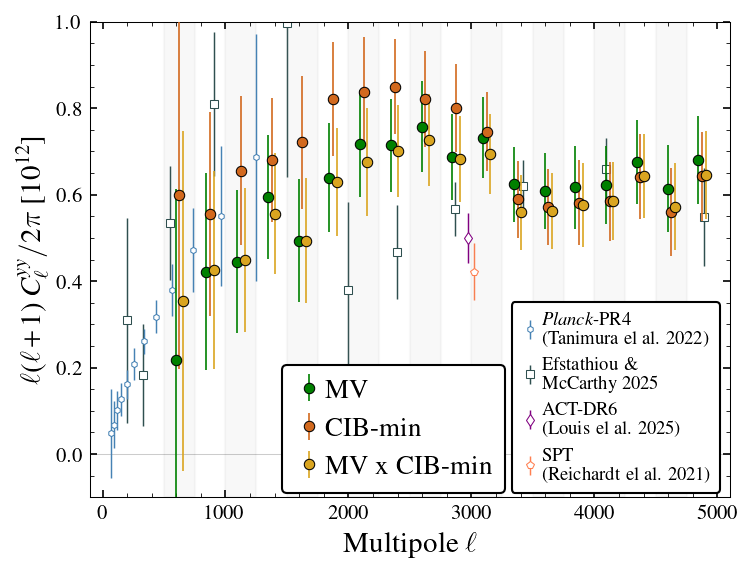

In [9]:
fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
print(res_dic.keys())

m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())
show_error_decomposition = False #True ##False

clf()
fsval = 14
if show_error_decomposition:
    fig = figure(figsize = (12., 4.5))
    subplots_adjust(wspace = 0.02, hspace = 0.05)
    tr, tc = 3, 3
    ymin, ymax = -0.1, 1.1
else:
    fig = figure(figsize = (5.5, 4.2))
    tr, tc = 1, 1
    ymin, ymax = -0.1, 1.
xmin, xmax = -100., 5100.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

#left panel - Final tSZ estimate for all ILC combinations with total error.
if show_error_decomposition:
    rspan, cspan = 3, 1
    ax = subplot2grid((tr, tc), (0, 0), rowspan = rspan, colspan = cspan)
    mkrval1, msval1 = '.', 1.5
    mkrval2, msval2 = '.', 1.5
    mkrval3, msval3 = '.', 1.5
    xshiftval = -40.
    xshiftdeltaval = abs(xshiftval)
else:
    ax = subplot(111)
    mkrval1, msval1 = 'o', 5.
    mkrval2, msval2 = 'o', 5.
    mkrval3, msval3 = 'o', 5.
    xshiftval = -30.
    xshiftdeltaval = abs(xshiftval)

pl_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }
results_for_cr_dic = {}
for m1m2 in m1_m2_ilc_comb_arr_to_plot:
    print(res_dic[m1m2].keys())
    el_ = res_dic[m1m2]['els']
    cl_data_final = res_dic[m1m2]['data_final'] * mulfac
    cl_data_err = res_dic[m1m2]['data_error'] * mulfac
    cl_tot_cov = res_dic[m1m2]['total_cov'] * mulfac**2.
    ##print( cl_data_err )
    ##print( np.sqrt( np.diag(cl_tot_cov) ) ); sys.exit()

    linds = np.where(el_<=lmax_for_plotting)[0]
    el_, cl_data_final, cl_data_err = el_[linds], cl_data_final[linds], cl_data_err[linds]
    cl_tot_cov = cl_tot_cov[linds[:,None], linds[None, :]]
    ##print( cl_data_err, np.sqrt( np.diag(cl_tot_cov) ) ); sys.exit()
    dl_fac = el_ * (el_+1)/2/np.pi
    
    results_for_cr_dic[m1m2] = {}
    results_for_cr_dic[m1m2]['els'] = el_
    results_for_cr_dic[m1m2]['bandpower'] = cl_data_final    
    results_for_cr_dic[m1m2]['bandpower_error'] = cl_data_err    
    results_for_cr_dic[m1m2]['cov'] = cl_tot_cov
    
    
    colorval, labval, mkrval, msval = pl_specs_dic[m1m2]
    lwval = 0.8
    errorbar(el_ + xshiftval, dl_fac * cl_data_final, 
             yerr = dl_fac * cl_data_err, 
             color = colorval, mec = 'black', mew = 0.5, 
             ls ='None', 
             label = labval, 
             capsize = capsizeval, 
             marker = mkrval, ms = msval,
             elinewidth = lwval, ecolor = colorval, 
             zorder = 10000,
            )
    xshiftval += xshiftdeltaval

#show Planck
planck_pr4_data_fname = 'data/planck_compton_y_PR4.txt'
planck_leff, planck_dlyy, planck_dlyy_err, planck_dlyy_fit = np.loadtxt(planck_pr4_data_fname, usecols = [2,3,4,5], unpack = True)
#planck_dlyy, planck_dlyy_err, planck_dlyy_fit = planck_dlyy/1e12, planck_dlyy_err/1e12, planck_dlyy_fit/1e12
planck_colorval = 'steelblue'
facecolor = 'white' #planck_colorval
msval = 3.
tmplwval, tmpcapsizeval = 0.7, 0
errorbar(planck_leff, planck_dlyy, xerr = None, yerr = planck_dlyy_err, 
         marker = 'h', 
         ms = msval, mew = 0.5, 
         mec = planck_colorval, 
         ecolor = planck_colorval, color = facecolor, capsize = tmpcapsizeval, 
         ls = 'None', label = '{\it Planck}-PR4' + '\n' + '(Tanimura el al. 2022)', 
         zorder = 1000.,
         elinewidth = tmplwval,
        )

if (1): #add ACT and SPT data points here.
        
    #https://arxiv.org/pdf/2502.10232
    tmpfname = 'data/Efstathiou_2025.txt'
    tmpel, tmpdlyy, tmpdlyy_err = np.loadtxt( tmpfname, unpack = True )
    tmpcolorval = 'darkslategrey' #cadetblue' #tab:pink'
    tmplabval = r'Efstathiou \&' + '\n' + 'McCarthy 2025'
    #tmplabval = r'EM25'
    errorbar( tmpel, tmpdlyy, yerr = tmpdlyy_err, mec = tmpcolorval, ecolor = tmpcolorval, 
              marker = 's', ms = msval+1, mew = 0.5, color = 'white', capsize = tmpcapsizeval, 
                 ls = 'None', label = tmplabval, 
                 zorder = -10.,
                 elinewidth = tmplwval)

    #ACT and SPT
    tsz_150_compton_y_fac = -2.6087267662385223
    tsz_143_compton_y_fac = -2.8458737521910122
    
    act_points = [3.4, 0.4, 3000, tsz_150_compton_y_fac]
    spt_points = [3.42, 0.54, 3000, tsz_143_compton_y_fac]
    act_spt_points_dic = {'act': [r'ACT-DR6' + '\n' + '(Louis el al. 2025)', 'purple', 'd', act_points], 
                         'spt': [r'SPT' + '\n' + '(Reichardt el al. 2021)', 'coral', 'p', spt_points],
                         }
    msval = 4.
    facecolor = 'white'
    capsizeval = 1.
    xshiftval, xdeltaval = -25, 50
    for act_spt_keyname in act_spt_points_dic:
        labval, colorval, mkrval, points = act_spt_points_dic[act_spt_keyname]
        dl_tsz, dl_tsz_err, el_norm, tsz_scalefac = points
        dl_yy = dl_tsz / tsz_scalefac**2.
        dl_yy_err = dl_tsz_err / tsz_scalefac**2.
        errorbar(el_norm + xshiftval, dl_yy, yerr = dl_yy_err, 
                 marker = mkrval, 
                 ms = msval, 
                 mec = colorval, mew = 0.5,
                 ecolor = colorval, color = facecolor, capsize = tmpcapsizeval, 
                 ls = 'None', label = labval, 
                 zorder = -10.,
                 elinewidth = tmplwval,
                )
        xshiftval += xdeltaval
        
    '''
    #SPT-3G D1
    tmpfname = 'data/spt3g_d1_highell_tt_cib_tsz_free.txt'
    tmpel, tmpdltsz, tmpdltsz_low, tmpdltsz_high = np.loadtxt( tmpfname, unpack = True )
    tmpdlyy = tmpdltsz / tsz_143_compton_y_fac**2.
    tmpdlyy_low = tmpdltsz_low / tsz_143_compton_y_fac**2.
    tmpdlyy_high = tmpdltsz_high / tsz_143_compton_y_fac**2.

    tmpdlyy_err_low = tmpdlyy - tmpdlyy_low
    tmpdlyy_err_high = tmpdlyy_high - tmpdlyy
    tmpcolorval = 'lightskyblue'
    tmplabval = r'SPT-3G: D1'
    errorbar( tmpel, tmpdlyy, yerr = [tmpdlyy_err_low, tmpdlyy_err_high], mec = tmpcolorval, ecolor = tmpcolorval, 
              marker = 's', ms = msval-0.5, color = 'white', capsize = capsizeval, 
                 ls = 'None', label = tmplabval, 
                 zorder = -10.,
                 elinewidth = lwval)
    '''
    
if (1): #add full sky spectra here.
    tsz_150_compton_y_fac = -2.6363439931018213
    mdpl2_cl_fname = 'data/cl_mdpl2_singlepixelsourcemask_radiocibmasked2.0mjy_fromalms_lmax13000.npy'
    mdpl2_cl_dic = np.load( mdpl2_cl_fname, allow_pickle = True ).item()
    mdpl2_cl_tsz_150 = mdpl2_cl_dic['tsz'][(150, 150)]
    mdpl2_cl_tsz_150 = mdpl2_cl_tsz_150 / (tsz_150_compton_y_fac**2.) 
    print(mdpl2_cl_tsz_150)
    tmpel_ = np.arange( len( mdpl2_cl_tsz_150 ) )
    tmp_dl_fac = tmpel_ * (tmpel_+1) / 2/ np.pi
    ##plot(tmpel_, tmp_dl_fac * mdpl2_cl_tsz_150, color = 'gray', label = r'Agora', alpha = 0.5)    
    
    

#shades
ax = make_ver_shades(ax, el_)
if show_error_decomposition:
    title(r'tSZ-only bandpowers', fontsize = fsval)

xlabel(r'Multipole $\ell$', fontsize = fsval)
#setp(ax.get_xticklabels(), visible=False)
ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
#setp(ax.get_yticklabels(), visible=False)
xlim(xmin, xmax); ylim(ymin, ymax)
#legfsval = fsval - 4.
#legend(loc = 2, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)

# Create the first legend
handles, labels = ax.get_legend_handles_labels()
sep_ind = 3

legfsval = fsval-1
yloc = -0.02
leg1 = ax.legend(handles[:sep_ind], labels[:sep_ind], bbox_to_anchor = (0.67, yloc), loc = 4, fontsize = legfsval, ncol = 1, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1, framealpha = 1.)
#leg1.get_frame().set_edgecolor('whitesmoke')
ax.add_artist(leg1)
leg2 = ax.legend(handles[sep_ind:], labels[sep_ind:], bbox_to_anchor = (1., yloc+0.01), loc = 4, fontsize = legfsval-4., ncol = 1, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1, framealpha = 1.)
#leg2.get_frame().set_edgecolor('whitesmoke')

#legfsval = fsval-3.5
#legend(loc = 4, fontsize = legfsval, ncol = 1, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
    
plname = 'plots/ymap_spectra_data'
np.save('results/100d_tsz_final_estimate_for_CR.npy', results_for_cr_dic)
########################################################################
########################################################################
########################################################################
if show_error_decomposition:
    #right panel - Final tSZ estimate for each ILC combinations with all the errors.
    xmin= 400.
    pl_specs_dic = {
                    'cib': ['orangered', r'CIB', '.', 1.5], 
                    'rad': ['royalblue', r'Radio', '.', 1.5], 
                    'cmb': ['goldenrod', r'CMB', '.', 1.5],
                    'stat': ['darkgreen', r'Stat-only', '.', 1.5],
                    'total': ['black', r'Total', '.', 1.5],
                   }

    title_dic = {('ymv', 'ymv'): r'MV', 
                    ('ycibfree', 'ycibfree'): r'CIB-min', 
                    ('ycibfree', 'ymv'): r'MV x CIB-min',
                   }

    rspan, cspan = 1, 1
    cmb_mul_fac = 10
    if cmb_mul_fac != 1:
        pl_specs_dic['cmb'][1] = r'CMB($\times$%g)' %(cmb_mul_fac)
    for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):

        ax = subplot2grid((tr, tc), (m1m2cntr, 1), rowspan = rspan, colspan = cspan)

        ##print(res_dic[m1m2].keys())
        el_ = res_dic[m1m2]['els']
        cl_data_final = res_dic[m1m2]['data_final'] * mulfac

        #covs
        cl_stat_cov = res_dic[m1m2]['stat_cov']
        cl_tot_cov = res_dic[m1m2]['total_cov']
        curr_cov_sys_dic = res_dic[m1m2]['cov_sys_dic']
        cl_cib_cov, cl_rad_cov, cl_cmb_cov = curr_cov_sys_dic['cib_tweaked'], curr_cov_sys_dic['rad_tweaked'], curr_cov_sys_dic['cmb']

        #errors
        cl_data_err = res_dic[m1m2]['data_error'] * mulfac
        cl_total_err = np.sqrt( np.diag(cl_tot_cov) ) * mulfac
        cl_stat_err = np.sqrt( np.diag(cl_stat_cov) ) * mulfac
        cl_cib_sys_err = np.sqrt( np.diag(cl_cib_cov) ) * mulfac
        cl_rad_sys_err = np.sqrt( np.diag(cl_rad_cov) ) * mulfac
        cl_cmb_sys_err = np.sqrt( np.diag(cl_cmb_cov) ) * mulfac * cmb_mul_fac

        linds = np.where(el_<=lmax_for_plotting)[0]
        el_, cl_data_final, cl_data_err = el_[linds], cl_data_final[linds], cl_data_err[linds]
        dl_fac = el_ * (el_+1)/2/np.pi
        to_plot_err_dic = {
                           'total': cl_total_err[linds],
                           'stat': cl_stat_err[linds], 
                           'cmb': cl_cmb_sys_err[linds], 
                           'cib': cl_cib_sys_err[linds], 
                           'rad': cl_rad_sys_err[linds], 
                          }

        xshiftval = -60.
        xshiftdeltaval = 30
        for err_key in to_plot_err_dic:

            colorval, labval, mkrval, msval = pl_specs_dic[err_key]
            lwval, msval = 0.8, 0.
            curr_cl_err = to_plot_err_dic[err_key]
            errorbar(el_ + xshiftval, dl_fac * cl_data_final, 
                     yerr = dl_fac * curr_cl_err, 
                     color = colorval, 
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval,
                     elinewidth = lwval, 
                    )
            xshiftval += xshiftdeltaval

        #shades
        ax = make_ver_shades(ax, el_)
        ax = format_axis(ax, fsval, fsval)

        #title
        title_val = title_dic[m1m2]
        title(title_val, y = 0.75, x = 0.95, fontsize = fsval - 3., ha = 'right')


        if m1m2cntr == 0:
            legfsval = fsval - 5.2
            legend(loc = 4, bbox_to_anchor = (1., -0.04), fontsize = legfsval, ncol = 5, handletextpad = 0.1, columnspacing = 0.2, handlelength = 1., numpoints = 1)

        if m1m2cntr == 2:
            xlabel(r'Multipole $\ell$', fontsize = fsval)
        else:
            setp(ax.get_xticklabels(), visible=False)
        #ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
        setp(ax.get_yticklabels(), visible=False)
        xlim(xmin, xmax); ylim(ymin, ymax)

    suptitle(r'Error budgets', fontsize = fsval, y = 0.93)
    plname = '%s_plus_errors' %(plname)
    
plname = '%s.pdf' %(plname)
#plname = '%s.png' %(plname)
savefig(plname, dpi = 200.)
show()



# Plot 4 - rc4 vs rc5 beam results

dict_keys([('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')])
dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_sim_all_signals', 'cl_arr_sim_tsz', 'sim_all_signals_keyname', 'sim_tsz_only', 'cl_sim_all_signals_full', 'sim_all_signals_full_keyname', 'noise', 'cl_sys_dic', 'stat_cov', 'cl_arr_for_gau_cov', 'stat_cov_non_gau', 'cl_arr_for_non_gau_cov', 'total_cov', 'cov_sys_dic'])
dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_sim_all_signals', 'cl_arr_sim_tsz', 'sim_all_signals_keyname', 'sim_tsz_only', 'cl_sim_all_signals_full', 'sim_all_signals_full_keyname', 'noise', 'cl_sys_dic', 'stat_cov', 'cl_arr_for_gau_cov', 'stat_cov_non_gau', 'cl_arr_for_non_gau_cov', 'total_cov', 'cov_sys_dic'])
dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_s

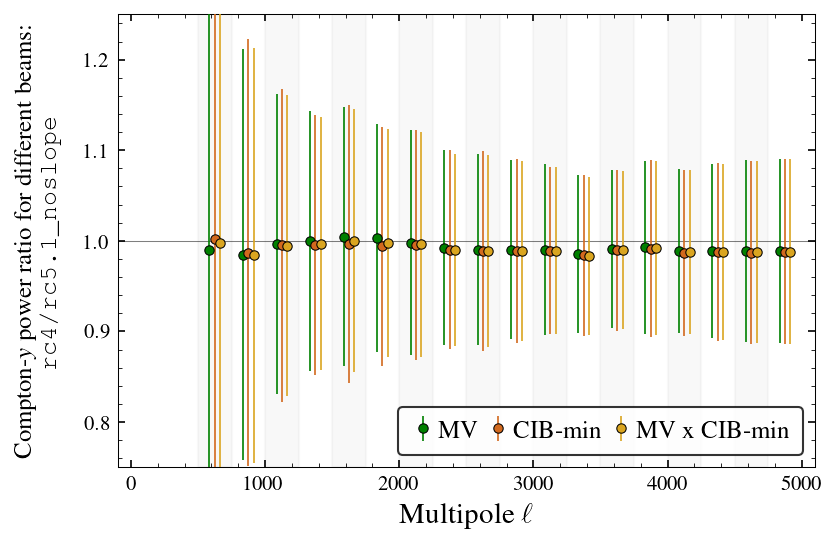

In [37]:

clf()
fsval = 14
tr, tc = 1, 1
ymin, ymax = -0.1, 1.
xmin, xmax = -100., 5100.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

ax = subplot(111)
msval = 4.5
pl_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval],
               }

#m1_m2_ilc_comb_arr_to_plot = [('ycibfree', 'ycibfree')]
m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())

pl_dic = {}
for beam_iter in range(2):
    if beam_iter == 0:
        fname = 'results/100d_tsz_final_estimate.npy'
    else:
        fname = 'results/100d_tsz_final_estimate_beamrc5.1_noslope.npy'

    res_dic = np.load(fname, allow_pickle=True).item()
    print(res_dic.keys())

    pl_dic[beam_iter] = {}
    for m1m2 in m1_m2_ilc_comb_arr_to_plot:
        print(res_dic[m1m2].keys())
        el_ = res_dic[m1m2]['els']
        cl_data_final = res_dic[m1m2]['data_final'] * mulfac
        cl_data_err = res_dic[m1m2]['data_error'] * mulfac
        cl_tot_cov = res_dic[m1m2]['total_cov'] * mulfac**2.
        ##print( cl_data_err )
        ##print( np.sqrt( np.diag(cl_tot_cov) ) ); sys.exit()

        linds = np.where(el_<=lmax_for_plotting)[0]
        el_, cl_data_final, cl_data_err = el_[linds], cl_data_final[linds], cl_data_err[linds]
        cl_tot_cov = cl_tot_cov[linds[:,None], linds[None, :]]
        ##print( cl_data_err, np.sqrt( np.diag(cl_tot_cov) ) ); sys.exit()
        dl_fac = el_ * (el_+1)/2/np.pi

        results_for_cr_dic[m1m2] = {}
        results_for_cr_dic[m1m2]['els'] = el_
        results_for_cr_dic[m1m2]['bandpower'] = cl_data_final    
        results_for_cr_dic[m1m2]['bandpower_error'] = cl_data_err    
        results_for_cr_dic[m1m2]['cov'] = cl_tot_cov
        
        pl_dic[beam_iter][m1m2] = [el_, cl_data_final, cl_data_err]


clf()
xshiftval = -40.
xshiftdeltaval = 40
for m1m2 in m1_m2_ilc_comb_arr_to_plot:
    colorval, labval, mkrval, msval = pl_specs_dic[m1m2]
    el_1, cl_data_final_1, cl_data_err_1 = pl_dic[0][m1m2]
    el_2, cl_data_final_2, cl_data_err_2 = pl_dic[1][m1m2]    

    errorbar(el_1 + xshiftval, cl_data_final_1/cl_data_final_2, 
         yerr = dl_fac * cl_data_err_1, 
         color = colorval, mec = 'black', mew = 0.5, 
         ls ='None', 
         label = labval, 
         capsize = capsizeval, 
         marker = mkrval, ms = msval,
         elinewidth = lwval, ecolor = colorval, 
         zorder = 10000,
        )
    xshiftval += xshiftdeltaval

#shades
ax = make_ver_shades(ax, el_)

axhline(1., alpha = 0.5, lw = 0.5)
xlabel(r'Multipole $\ell$', fontsize = fsval)
ylab = r'Compton-$y$ power ratio for different beams:' + '\n' + r'\texttt{rc4/rc5.1_noslope}'
ylabel(ylab, fontsize = fsval-2, labelpad = 10)
xlim(xmin, xmax); 
ylim(0.75, 1.25)
legfsval = fsval - 2
legend(loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)

    
show()



# Plot 3 - Compton-y power spectra: 100d and 100d x SPT-SZ

In [27]:
if (0):
    fname = 'results/100d_tsz_final_estimate.npy'
    res_dic = np.load(fname, allow_pickle=True).item()
    print(res_dic.keys())

    fname_sptsz_cross = 'results/100d_tsz_cross_sptsz.npy'
    res_dic_sptsz_cross = np.load(fname_sptsz_cross, allow_pickle=True).item()
    print(res_dic_sptsz_cross.keys())

    fname_planck_cross = 'results/100d_tsz_cross_planck.npy'
    res_dic_planck_cross = np.load(fname_planck_cross, allow_pickle=True).item()
    print(res_dic_planck_cross.keys())

    m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())

    close('all')
    clf()
    xmin, xmax = 400., 5100.
    lmax_for_plotting = 5000.
    capsizeval = 0.
    mulfac = 1e12
    fsval = 14
    fig = figure(figsize = (5.5, 4.2))
    yscaleval = None
    ymin, ymax = -0.1, 2. #2.2 ##2.2 #1.1
    xshiftval = -75.
    xshiftdeltaval = 25. ##abs(xshiftval)

    mkrval1, msval1 = 'o', 2.
    mkrval2, msval2 = 'o', 2.
    mkrval3, msval3 = 'o', 2.
    sptsz_cross_msval = 3.
    pl_specs_dic = {('ymv', 'ymv'): ['darkgreen', r'MV', mkrval1, msval1], 
                    ('ycibfree', 'ycibfree'): ['darkred', r'CIB-min', mkrval2, msval2], 
                    ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
                    ('sptsz_ymv', 'ymv'): ['darkgreen', r'MV x SPT-SZ MV', 'D', sptsz_cross_msval], 
                    ('sptsz_ymv', 'ycibfree'): ['darkred', r'CIB-min x SPT-SZ MV', 'D', sptsz_cross_msval], 
                    ('sptsz_ycmbfree', 'ymv'): ['darkgreen', r'MV x SPT-SZ CMB-null', 'D', sptsz_cross_msval], 
                    ('sptsz_ycmbfree', 'ycibfree'): ['darkred', r'CIB-min x SPT-SZ CMB-null', 'D', sptsz_cross_msval], 
                    ('planck_ymv_half1', 'planck_ymv_half2'): ['navy', r'{\it Planck} PR4', 'D', sptsz_cross_msval], 
                    ('planck_ymv_full', 'ymv'): ['darkgreen', r'MV x {\it Planck}', 'D', sptsz_cross_msval], 
                    ('planck_ymv_full', 'ycibfree'): ['darkred', r'CIB-min x {\it Planck}', 'D', sptsz_cross_msval], 
                   }

    title_dic = {('ymv', 'ymv'): r'MV', 
                    ('ycibfree', 'ycibfree'): r'CIB-min', 
                    ('ycibfree', 'ymv'): r'MV x CIB-min',
                   }

    ax = subplot(111, yscale = yscaleval, xscale = 'log')
    for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):

        ##print(res_dic[m1m2].keys())
        el_ = res_dic[m1m2]['els']
        el_ori = np.copy( el_ )
        cl_data= res_dic[m1m2]['data'] * mulfac
        cl_data_err = res_dic[m1m2]['data_error'] * mulfac

        #cl_sim = res_dic[m1m2]['sim'] * mulfac    
        if (1): #make sim with tSZ
            cl_sim_arr = res_dic[m1m2]['cl_for_sub_arr'] * mulfac
            cl_sim_tsz_arr = res_dic[m1m2]['cl_arr_sim_tsz'][1] * mulfac
            cl_sim_arr = cl_sim_arr + cl_sim_tsz_arr
            cl_sim = np.mean(cl_sim_arr, axis = 0)


        linds = np.where(el_<=lmax_for_plotting)[0]
        el_, cl_data, cl_sim, cl_data_err = el_[linds], cl_data[linds], cl_sim[linds], cl_data_err[linds]
        dl_fac = el_ * (el_+1)/2/np.pi 

        #plot data
        colorval, labval, mkrval, msval = pl_specs_dic[m1m2]
        lwval = 0.7
        facecolorval = colorval #'None'
        errorbar(el_ + xshiftval, dl_fac * cl_data, 
                 yerr = dl_fac * cl_data_err, 
                 mec = colorval, 
                 ecolor = colorval, color = facecolorval,
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, 
                 zorder = 100,
                )

        #plot sims
        ##colorval, labval, lwval = 'black', r'Sim (no-tSZ)', 1.
        lwval = 1.
        ##plot( el_, dl_fac * cl_sim, color = colorval, lw = lwval)#, label = labval, zorder = 50)

        xshiftval += xshiftdeltaval

    xshiftval += xshiftdeltaval
    if (0):
        m1m2_sptszcross_arr = [('sptsz_ymv', 'ymv'), ('sptsz_ymv', 'ycibfree')]
        #m1m2_sptszcross_arr = [('sptsz_ycmbfree', 'ymv'), ('sptsz_ycmbfree', 'ycibfree')]
        for m1m2_sptszcross in m1m2_sptszcross_arr:
            el_sptszcross, cl_full_sptszcross, cl_half1_sptszcross, cl_half2_sptszcross, cl_bundle_arr_sptszcross = res_dic_sptsz_cross[m1m2_sptszcross]
            cl_full_sptszcross = cl_full_sptszcross[linds] * mulfac
            #dl_fac_sptszcross = el_sptszcross * (el_sptszcross+1)/2/np.pi * mulfac
            colorval, labval, mkrval, msval = pl_specs_dic[m1m2_sptszcross]
            facecolorval = 'white'
            lwval = 0.7
            mew = 0.5
            errorbar(el_ + xshiftval, dl_fac * cl_full_sptszcross, 
                     yerr = dl_fac * cl_data_err, 
                     mec = colorval, 
                     ecolor = colorval, color = facecolorval,
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval, mew = mew, 
                     elinewidth = lwval, 
                     zorder = 100,
                    )
            xshiftval += xshiftdeltaval

        figtext(0.15, 0.82, r'{\bf Note:} Errors for SPT-SZx are wrong', fontsize = 8.5, color = 'orangered',  
                bbox=dict(facecolor='white',  # Background color of the box
                alpha=1.,             # Transparency of the box
                boxstyle='round,pad=0.5'),
                )
        legfsval = fsval - 3
        legend(loc = 4,
               fontsize = legfsval, ncol = 2, handletextpad = 0.4, columnspacing = 0.5, 
               handlelength = 1.5, numpoints = 1,
              framealpha = 1.)
        ax = format_axis(ax, fsval, fsval)

    if (1): #Include Planck cross
        m1m2_planckcross_arr = [('planck_ymv_half1', 'planck_ymv_half2'), ('planck_ymv_full', 'ymv'), ('planck_ymv_full', 'ycibfree')]
        #m1m2_planckcross_arr = [('planck_ymv_half1', 'planck_ymv_half2')]
        for m1m2_planckcross in m1m2_planckcross_arr:
            el_planckcross, cl_planckcross= res_dic_planck_cross[m1m2_planckcross]
            cl_planckcross = cl_planckcross * mulfac
            cl_planckcross[el_planckcross>2000] = 0.

            dl_fac_to_plot = el_planckcross * (el_planckcross+1)/2/np.pi
            el_to_plot = el_planckcross
            cl_data_err_to_plot = 0.

            """
            cl_planckcross = cl_planckcross[linds]
            #dl_fac_planckcross = el_planckcross * (el_planckcross+1)/2/np.pi
            dl_fac_to_plot = dl_fac
            el_to_plot = el_
            cl_data_err_to_plot = cl_data_err
            """
            colorval, labval, mkrval, msval = pl_specs_dic[m1m2_planckcross]
            facecolorval = 'white'
            lwval = 0.7
            mew = 1. #0.5
            plot(el_to_plot + xshiftval, dl_fac_to_plot * cl_planckcross, color = facecolorval, mec = colorval, 
                     ls ='None', 
                     label = labval, 
                     marker = mkrval, ms = msval, mew = mew, 
                     zorder = 100)
            """
            errorbar(el_to_plot + xshiftval, dl_fac_to_plot * cl_planckcross, 
                     yerr = dl_fac_to_plot * cl_data_err_to_plot, 
                     mec = colorval, 
                     ecolor = colorval, color = facecolorval,
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval, mew = mew, 
                     elinewidth = lwval, 
                     zorder = 100,
                    )
            """
            xshiftval += xshiftdeltaval        
        legfsval = fsval - 4
        legend(loc = 2,
               fontsize = legfsval, ncol = 2, handletextpad = 0.4, columnspacing = 0.5, 
               handlelength = 1.5, numpoints = 1,
              framealpha = 1.)
        ax = format_axis(ax, fsval-2, fsval-2)
    """
    # Get the handles and labels
    handles, labels = ax.get_legend_handles_labels()
    print(labels, len(labels))
    order, legncol = [2, 1, 0], 3  # Indices of the desired order in the original lists
    #order = [3, 2, 0, 1]  # Indices of the desired order in the original lists
    ordered_handles = [handles[i] for i in order]
    ordered_labels = [labels[i] for i in order]

    leg = legend(ordered_handles, ordered_labels, loc = 1, bbox_to_anchor = (1., 1.),
           fontsize = legfsval, ncol = legncol, handletextpad = 0.4, columnspacing = 1., 
           handlelength = 1.5, numpoints = 1,
          framealpha = 1.)
    """


    #shades
    ax = make_ver_shades(ax, el_)

    ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    xlim(xmin, xmax); ylim(ymin, ymax)



# Plot 4 - Compton-y power spectra and systematics

dict_keys([('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')])
['Sim expectation (No tSZ)' 'CMB' 'CIB' 'kSZ' 'Radio' 'Data'] 6


/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_2891/1629509724.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  handles = np.asarray(handles)


<Figure size 900x600 with 0 Axes>

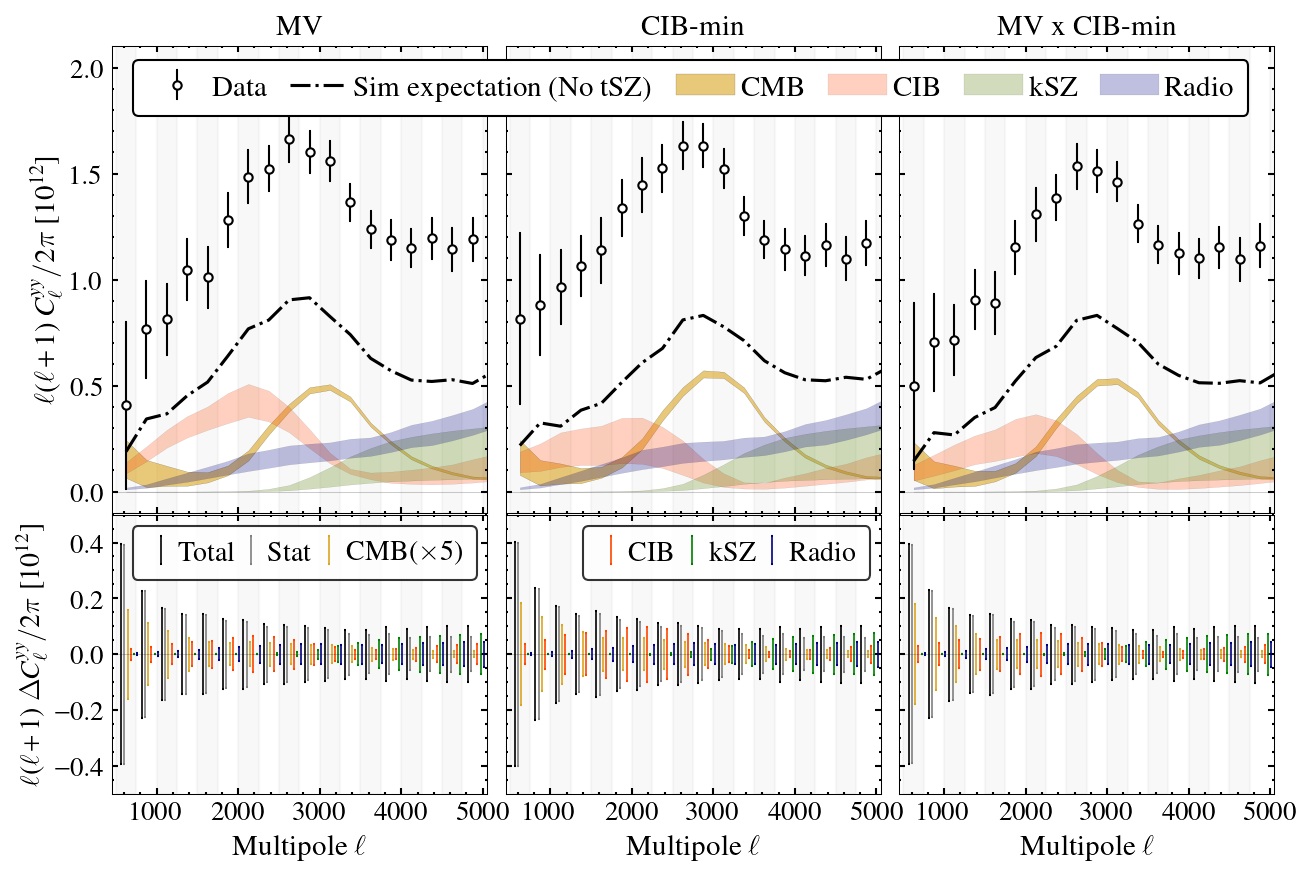

In [28]:
#%matplotlib notebook
#%matplotlib inline
fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
print(res_dic.keys())

m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())
adding_analytic_radio = False

show_error_decomposition = True #False ##True

clf()
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0.5
mulfac = 1e12
fsval = 14
axfsval = fsval - 1
tr, tc = 1, 3
if show_error_decomposition:
    tr = 8
    rspan = 5
    fig = figure(figsize = (10., 6.6))
    subplots_adjust(wspace = 0.05, hspace = 0.02)
else:
    fig = figure(figsize = (10., 4.1))
    subplots_adjust(wspace = 0.05, hspace = 0.05)

yscaleval = None
if yscaleval is None:
    ymin, ymax = -0.1, 2.1 ##2.2 #1.1
elif yscaleval == 'log':
    ymin, ymax = 0.05, 20.


#Three panels - Total data, total sims w/o tSZ, final tSZ estimate, and all the individual signals for each ILC combinations.
pl_specs_dic = {
                'cib_tweaked': ['orangered', r'CIB', 1., 0.25], 
                'cib_tweaked_spt_only': ['orangered', r'CIB', 1., 0.25], 
                'cib_tweaked_spt_only_max_tweak_0.2': ['orangered', r'CIB', 1., 0.25], 
                'cib_tweaked_max_tweak_0.2': ['orangered', r'CIB', 1., 0.25], 
                #
                'rad_tweaked': ['navy', r'Radio', 1., 0.25], 
                'rad_tweaked_spt_only_max_tweak_0.2': ['royalblue', r'Radio', 1., 0.25], 
                'rad_tweaked_max_tweak_0.2': ['navy', r'Radio', 1., 0.25], 
                #
                'cmb': ['goldenrod', r'CMB', 1., 0.6],
                'cmb_withspiretcalerror': ['goldenrod', r'CMB', 1., 0.6],
                #
                'ksz': ['olivedrab', r'kSZ', 1., 0.3],
                #
                'total': ['black', r'Total', 1., 0.8],
               }

title_dic = {('ymv', 'ymv'): r'MV', 
                ('ycibfree', 'ycibfree'): r'CIB-min', 
                ('ycibfree', 'ymv'): r'MV x CIB-min',
               }

for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):

    ax = subplot2grid((tr, tc), (0, m1m2cntr), yscale = yscaleval, rowspan = rspan)
        

    ##print(res_dic[m1m2].keys())
    el_ = res_dic[m1m2]['els']
    el_ori = np.copy( el_ )
    cl_data= res_dic[m1m2]['data'] * mulfac
    cl_sim = res_dic[m1m2]['sim'] * mulfac
    cl_data_final = res_dic[m1m2]['data_final'] * mulfac
    cl_data_err = res_dic[m1m2]['data_error'] * mulfac

    ##linds = np.where(el_<=lmax_for_plotting)[0]
    ##el_, cl_data, cl_sim, cl_data_final, cl_data_err = el_[linds], cl_data[linds], cl_sim[linds], cl_data_final[linds], cl_data_err[linds]
    dl_fac = el_ * (el_+1)/2/np.pi 

    #plot data
    #colorval, labval, mkrval, msval, lwval = 'black', r'Data: Total', 'o', 4., 1.
    colorval, labval, mkrval, msval, lwval = 'black', r'Data', 'o', 4., 1.
    facecolorval = 'white'
    errorbar(el_, dl_fac * cl_data, 
             yerr = dl_fac * cl_data_err, 
             mec = colorval, 
             ecolor = colorval, color = facecolorval,
             ls ='None', 
             label = labval, 
             capsize = capsizeval, 
             marker = mkrval, ms = msval,
             elinewidth = lwval, 
             zorder = 100,
            )

    #plot sims
    colorval, labval, lwval = 'black', r'Sim expectation (No tSZ)', 1.5
    plot( el_, dl_fac * cl_sim, color = colorval, label = labval, lw = lwval, ls = '-.', zorder = 50)
    
    '''
    #plot data final
    colorval, labval, mkrval, msval, lwval = 'black', r'Data: tSZ-only', 'o', 4., 1.
    errorbar(el_, dl_fac * cl_data_final, 
             yerr = dl_fac * cl_data_err, 
             color = colorval, 
             ls ='None', 
             label = labval, 
             capsize = capsizeval, 
             marker = mkrval, ms = msval,
             elinewidth = lwval, 
             zorder = 100,
            )    
    '''
    if (1):
        which_cib_tweak = 'cib_tweaked_spt_only_max_tweak_0.2'
        which_rad_tweak = 'rad_tweaked_max_tweak_0.2'
        #systematics
        curr_cl_sys_dic = res_dic[m1m2]['cl_sys_dic']
        #sys_signal_arr_to_plot = ['cmb', 'cib_tweaked', 'rad_tweaked']
        #sys_signal_arr_to_plot = ['cmb', 'cib_tweaked_spt_only_max_tweak_0.2', 'rad_tweaked']
        #sys_signal_arr_to_plot = ['cmb', 'cib_tweaked_spt_only', 'rad_tweaked']
        #sys_signal_arr_to_plot = ['cmb', 'cmb_withspiretcalerror', 'cib_tweaked_max_tweak_0.2', 'rad_tweaked_max_tweak_0.2']
        sys_signal_arr_to_plot = ['cmb_withspiretcalerror', which_cib_tweak, 'ksz', which_rad_tweak]
        #sys_signal_arr_to_plot = ['cmb_withspiretcalerror', 'cib_tweaked_max_tweak_0.2']
        #sys_signal_arr_to_plot = ['cib_tweaked', 'cib_tweaked_spt_only']
        #sys_signal_arr_to_plot = ['rad_tweaked', 'rad_tweaked_spt_only_max_tweak_0.2']
        to_plot_sys_signal_dic = {}
        to_plot_sys_signal_envelope_dic = {}
        for sys_signal in sys_signal_arr_to_plot:
            curr_cl_sys_arr = curr_cl_sys_dic[sys_signal] * mulfac

            curr_cl_sys_envelope = []
            for elcntr, curr_el in enumerate( el_ori ):
                sys_minval, sys_maxval = min(curr_cl_sys_arr[:, elcntr]), max(curr_cl_sys_arr[:, elcntr])
                #print(curr_cl_sys_arr[elcntr])
                #print(sys_minval, sys_maxval); sys.exit()
                curr_cl_sys_envelope.append( [sys_minval, sys_maxval] )
            curr_cl_sys_envelope = np.asarray(curr_cl_sys_envelope)#[linds, :]

            to_plot_sys_signal_dic[sys_signal] = curr_cl_sys_arr##[:, linds]
            to_plot_sys_signal_envelope_dic[sys_signal] = curr_cl_sys_envelope


        for sys_signal in to_plot_sys_signal_dic:

            colorval, labval, lwval, alphaval = pl_specs_dic[sys_signal]

            curr_cl_sys_arr = to_plot_sys_signal_dic[sys_signal]##[:25]
            curr_cl_sys_envelope = to_plot_sys_signal_envelope_dic[sys_signal]

            dl_fac_ori = el_ori * (el_ori+1)/2/np.pi
            fill_between(el_ori, 
                         dl_fac_ori * curr_cl_sys_envelope[:,0], dl_fac_ori * curr_cl_sys_envelope[:,1], 
                         color = colorval, 
                         alpha = alphaval,
                         lw = 0.1, edgecolor = 'black',
                         label = labval,
                         ##ls = (0, (3, 3)),
                        )

        if (0): #also show analytic radio residuals
            adding_analytic_radio = True
            analytic_radio_dnds_dic_to_plot = {'dezotti': ['navy', '--', 1., r'de Zotti'], 
                                               'tucci': ['navy', '-.', 1., r'Tucci'],
                                               'lagache': ['navy', '-', 1., r'Lagache'], 
                                              }
            for analytic_radio_dnds in analytic_radio_dnds_dic_to_plot:
                curr_cl_sys_radio_dnds = curr_cl_sys_dic['analytic_radio'][analytic_radio_dnds] * mulfac
                colorval, lsval, lwval, labval = analytic_radio_dnds_dic_to_plot[analytic_radio_dnds]
                plot( el_ori, dl_fac_ori * curr_cl_sys_radio_dnds, 
                     color = colorval, 
                     ls = lsval, 
                     lw = lwval, 
                     label = labval,
                     zorder = 50)
            xlim(xmin, xmax)
            show(); sys.exit()

    if m1m2cntr == 2:
        legfsval = fsval - 0.5
        """
        legend(loc = 1, bbox_to_anchor = (1., 1.),
               fontsize = legfsval, ncol = 1, handletextpad = 0.4, columnspacing = 1., 
               handlelength = 1.5, numpoints = 1,
              framealpha = 1.)
        """
        # Get the handles and labels
        handles, labels = ax.get_legend_handles_labels()
        handles = np.asarray(handles)
        labels = np.asarray(labels)        
        print(labels, len(labels))
        
        legfsval = fsval
        """
        xloc = 1
        inds1 = [5, 4, 0]
        leg1 = ax.legend(handles[inds1], labels[inds1], bbox_to_anchor = (xloc, 0.83), loc = 4, fontsize = legfsval, ncol = 3, handletextpad = 0.5, columnspacing = 0.5, numpoints = 1, framealpha = 1.)
        #leg1.get_frame().set_edgecolor('whitesmoke')
        ax.add_artist(leg1)
        inds2 = [1, 2, 3]
        leg2 = ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (xloc, 0.71), loc = 4, fontsize = legfsval-1, ncol = 3, handletextpad = 0.5, columnspacing = 0.5, numpoints = 1, framealpha = 1.)
        """
        inds2 = [5, 0, 1, 2, 3, 4]
        leg2 = ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)
        #leg2.get_frame().set_edgecolor('whitesmoke')        
        
        if adding_analytic_radio:
            ax.add_artist(leg)
            order, legncol = [1, 2, 3], 4  # Indices of the desired order in the original lists
            ordered_labels = [labels[i] for i in order]
            ordered_handles = [handles[i] for i in order]
            tmp = plot([], [], 'w-')
            ordered_labels = [r'{\bf Radio dN/dS:}'] + ordered_labels
            ordered_handles = tmp + ordered_handles

            leg = legend(ordered_handles, ordered_labels, loc = 1, bbox_to_anchor = (1., 0.89),
                   fontsize = legfsval-3, ncol = legncol, handletextpad = 0.2, columnspacing = 0.6, 
                   handlelength = 1.4, numpoints = 1,
                   framealpha = 1.)
            leg._legend_box.align = 'left'
        
    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, axfsval, axfsval)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    if show_error_decomposition:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    xlim(xmin, xmax); ylim(ymin, ymax)

plname = 'plots/ymap_spectra_data_simulations_sys_checks'
#plname = 'plots/ymap_spectra_data_simulations_sys_checks'
    
if show_error_decomposition:
    #right panel - Final tSZ estimate for each ILC combinations with all the errors.
    ymax = 1.
    pl_specs_dic = {
                    'cib': ['orangered', r'CIB', '.', 1.5], 
                    'rad': ['navy', r'Radio', '.', 1.5], 
                    'cmb': ['goldenrod', r'CMB', '.', 1.5],
                    'ksz': ['green', r'kSZ', '.', 1.5],
                    'stat': ['gray', r'Stat', '.', 1.5],
                    'total': ['black', r'Total', '.', 1.5],
                   }

    title_dic = {('ymv', 'ymv'): r'MV', 
                    ('ycibfree', 'ycibfree'): r'CIB-min', 
                    ('ycibfree', 'ymv'): r'MV x CIB-min',
                   }

    curr_rspan = tr-rspan
    cspan = 1
    cmb_mul_fac = 5
    if cmb_mul_fac != 1:
        pl_specs_dic['cmb'][1] = r'CMB($\times$%g)' %(cmb_mul_fac)
    for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):

        ax = subplot2grid((tr, tc), (rspan, m1m2cntr), rowspan = curr_rspan, colspan = cspan)

        ##print(res_dic[m1m2].keys())
        el_ = res_dic[m1m2]['els']
        cl_data_final = res_dic[m1m2]['data_final'] * mulfac

        #covs
        cl_stat_cov = res_dic[m1m2]['stat_cov']
        ##print(cl_stat_cov[0])
        cl_tot_cov = res_dic[m1m2]['total_cov']
        ##print(cl_tot_cov[0]); sys.exit()
        curr_cov_sys_dic = res_dic[m1m2]['cov_sys_dic']
        cl_cib_cov, cl_rad_cov, cl_cmb_cov = curr_cov_sys_dic['cib_tweaked'], curr_cov_sys_dic['rad_tweaked'], curr_cov_sys_dic['cmb']
        cl_ksz_cov = curr_cov_sys_dic['ksz']
        

        #errors
        cl_data_err = res_dic[m1m2]['data_error'] * mulfac
        cl_total_err = np.sqrt( np.diag(cl_tot_cov) ) * mulfac
        cl_stat_err = np.sqrt( np.diag(cl_stat_cov) ) * mulfac
        cl_cib_sys_err = np.sqrt( np.diag(cl_cib_cov) ) * mulfac
        cl_ksz_sys_err = np.sqrt( np.diag(cl_ksz_cov) ) * mulfac
        cl_rad_sys_err = np.sqrt( np.diag(cl_rad_cov) ) * mulfac
        cl_cmb_sys_err = np.sqrt( np.diag(cl_cmb_cov) ) * mulfac * cmb_mul_fac

        linds = np.where(el_<=lmax_for_plotting)[0]
        el_, cl_data_final, cl_data_err = el_[linds], cl_data_final[linds], cl_data_err[linds]
        dl_fac = el_ * (el_+1)/2/np.pi
        to_plot_err_dic = {
                           'total': cl_total_err[linds],
                           'stat': cl_stat_err[linds], 
                           'cmb': cl_cmb_sys_err[linds], 
                           'cib': cl_cib_sys_err[linds], 
                           'ksz': cl_ksz_sys_err[linds], 
                           'rad': cl_rad_sys_err[linds], 
                          }

        xshiftval = -60.
        xshiftdeltaval = 40
        for err_key in to_plot_err_dic:

            colorval, labval, mkrval, msval = pl_specs_dic[err_key]
            lwval, msval = 0.8, 0.
            curr_cl_err = to_plot_err_dic[err_key]
            errorbar(el_ + xshiftval, dl_fac * 0, 
                     yerr = dl_fac * curr_cl_err, 
                     color = colorval, 
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval,
                     elinewidth = lwval, 
                    )
            xshiftval += xshiftdeltaval

        #shades
        ax = make_ver_shades(ax, el_)
        ax = format_axis(ax, axfsval, axfsval)

        #title
        ##title_val = title_dic[m1m2]
        ##title(title_val, y = 0.75, x = 0.95, fontsize = fsval - 3., ha = 'right')
        """
        if m1m2cntr == 2:
            legfsval = fsval# - 1
            legend(loc = 1, bbox_to_anchor = (1., 1.), fontsize = legfsval, ncol = 6, handletextpad = 0.1, columnspacing = 0.1, handlelength = 1., numpoints = 1)
        """ 
        
        legfsval = fsval - 0.5
        if m1m2cntr == 0:
            handles, labels = ax.get_legend_handles_labels()
            legend(handles[:3], labels[:3], loc = 1, bbox_to_anchor = (1.01, 1.01), fontsize = legfsval, ncol = 6, handletextpad = 0.1, columnspacing = 0.1, handlelength = 1., numpoints = 1)
        if m1m2cntr == 1:
            handles, labels = ax.get_legend_handles_labels()
            legend(handles[3:], labels[3:], loc = 1, bbox_to_anchor = (1.01, 1.01), fontsize = legfsval, ncol = 6, handletextpad = 0.1, columnspacing = 0.1, handlelength = 1., numpoints = 1)

        if m1m2cntr == 0:
            ylabel(r'$\ell(\ell+1)\ \Delta C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval-0.5)
        else:
            setp(ax.get_yticklabels(), visible=False)
        xlabel(r'Multipole $\ell$', fontsize = fsval)
        xlim(xmin, xmax); ylim(-0.5, 0.5)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    ##suptitle(r'Error budgets', fontsize = fsval, y = 0.93)
    plname = '%s_plus_errors' %(plname)          
    
plname = '%s.pdf' %(plname)
#plname = '%s.png' %(plname)
savefig(plname, dpi = 200.)
show()



In [252]:
fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
tmpels = res_dic[m1m2]['els']
linds = np.arange(len(tmpels))
#linds = np.where(tmpels<4000)[0]
#linds = np.where(tmpels<3500)[0]
#linds = np.where(tmpels<3000)[0]
for m1m2 in m1m2_arr:
    print(m1m2)
    #D = res_dic[m1m2]['data']
    D = res_dic[m1m2]['data_final'][linds]
    C = res_dic[m1m2]['total_cov'][linds[None,:], linds[:,None]]
    print(C.shape)
    #C = res_dic[m1m2]['stat_cov_non_gau']
    #C = res_dic[m1m2]['stat_cov']
    Cinv = np.linalg.inv(C)
    chi_sq_val = np.dot(D, np.dot(D, Cinv))
    snr = np.sqrt( chi_sq_val )
    print( snr )
    
#SNR of Efstathiou and McCarthy
tmpfname = 'data/Efstathiou_2025.txt'
tmpels, tmpdlyy, tmpdlyy_err = np.loadtxt( tmpfname, unpack = True )

linds = np.arange(len(tmpels))
#linds = np.where(tmpels<2000)[0]
#linds = np.where(tmpels>2000)[0]

tmpels, tmpdlyy, tmpdlyy_err = tmpels[linds], tmpdlyy[linds], tmpdlyy_err[linds]

tmpcov = np.eye( len(tmpdlyy) ) * tmpdlyy_err**2
#print(tmpcov)

tmpcov_inv = np.linalg.inv(tmpcov)
tmpchi_sq_val = np.dot(tmpdlyy, np.dot(tmpdlyy, tmpcov_inv))
tmpsnr = np.sqrt( tmpchi_sq_val )
print( tmpsnr )


('ymv', 'ymv')
(26, 26)
11.87094155805738
('ycibfree', 'ycibfree')
(26, 26)
12.464689221986324
('ycibfree', 'ymv')
(26, 26)
11.680776864472229
20.61342364801839


In [121]:
print( 12.5/10.4 )
print( 12.5/10.3 )
print( 12.5/9.8 )


1.2019230769230769
1.2135922330097086
1.2755102040816326


# Plot xx - Compton-y power spectra errors

dict_keys([('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')])


<Figure size 900x600 with 0 Axes>

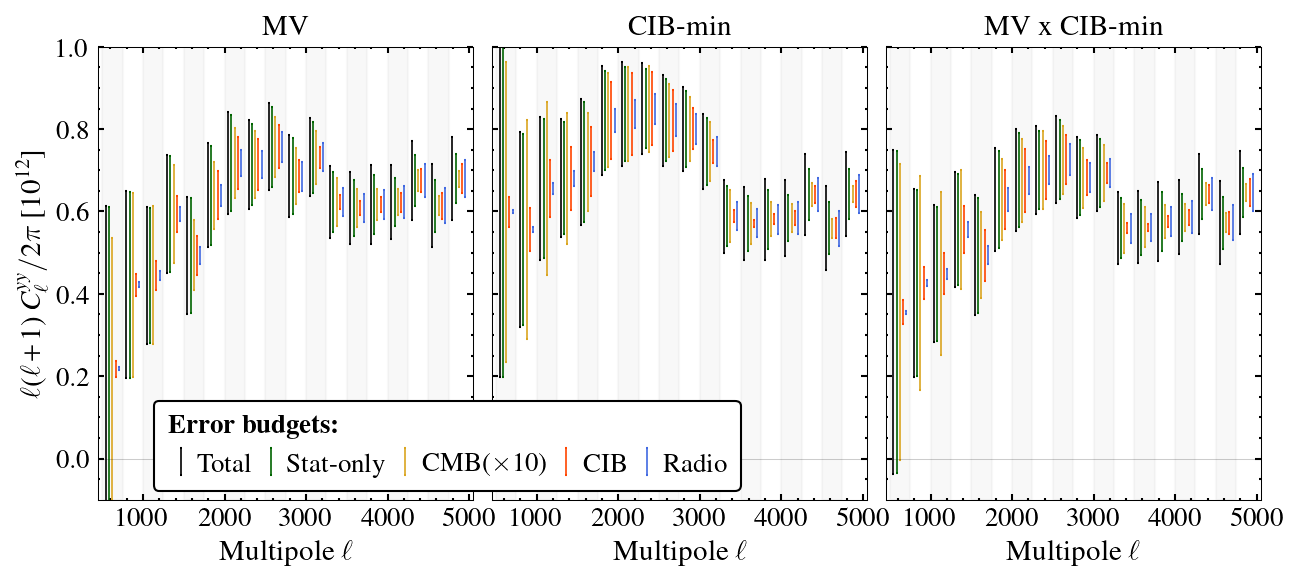

In [30]:
fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
print(res_dic.keys())

m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())

show_error_decomposition = False ##True

clf()
xmin, xmax = 450., 5050.
ymin, ymax = -0.1, 1. #1.1
lmax_for_plotting = 5000.
capsizeval = 0.5
mulfac = 1e12
fsval = 14
tr, tc = 1, 3
fig = figure(figsize = (10., 4.))
subplots_adjust(wspace = 0.05, hspace = 0.05)

pl_specs_dic = {
                'cib': ['orangered', r'CIB', '.', 1.5], 
                'rad': ['royalblue', r'Radio', '.', 1.5], 
                'cmb': ['goldenrod', r'CMB', '.', 1.5],
                'stat': ['darkgreen', r'Stat-only', '.', 1.5],
                'total': ['black', r'Total', '.', 1.5],
               }

title_dic = {('ymv', 'ymv'): r'MV', 
                ('ycibfree', 'ycibfree'): r'CIB-min', 
                ('ycibfree', 'ymv'): r'MV x CIB-min',
               }

cmb_mul_fac = 10
if cmb_mul_fac != 1:
    pl_specs_dic['cmb'][1] = r'CMB($\times$%g)' %(cmb_mul_fac)
for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):

    ax = subplot2grid((tr, tc), (0, m1m2cntr))

    ##print(res_dic[m1m2].keys())
    el_ = res_dic[m1m2]['els']
    cl_data_final = res_dic[m1m2]['data_final'] * mulfac

    #covs
    cl_stat_cov = res_dic[m1m2]['stat_cov']
    cl_tot_cov = res_dic[m1m2]['total_cov']
    curr_cov_sys_dic = res_dic[m1m2]['cov_sys_dic']
    cl_cib_cov, cl_rad_cov, cl_cmb_cov = curr_cov_sys_dic['cib_tweaked'], curr_cov_sys_dic['rad_tweaked'], curr_cov_sys_dic['cmb']

    #errors
    cl_data_err = res_dic[m1m2]['data_error'] * mulfac
    cl_total_err = np.sqrt( np.diag(cl_tot_cov) ) * mulfac
    cl_stat_err = np.sqrt( np.diag(cl_stat_cov) ) * mulfac
    cl_cib_sys_err = np.sqrt( np.diag(cl_cib_cov) ) * mulfac
    cl_rad_sys_err = np.sqrt( np.diag(cl_rad_cov) ) * mulfac
    cl_cmb_sys_err = np.sqrt( np.diag(cl_cmb_cov) ) * mulfac * cmb_mul_fac

    linds = np.where(el_<=lmax_for_plotting)[0]
    el_, cl_data_final, cl_data_err = el_[linds], cl_data_final[linds], cl_data_err[linds]
    dl_fac = el_ * (el_+1)/2/np.pi
    to_plot_err_dic = {
                       'total': cl_total_err[linds],
                       'stat': cl_stat_err[linds], 
                       'cmb': cl_cmb_sys_err[linds], 
                       'cib': cl_cib_sys_err[linds], 
                       'rad': cl_rad_sys_err[linds], 
                      }

    xshiftval = -80.
    xshiftdeltaval = 40
    for err_key in to_plot_err_dic:

        colorval, labval, mkrval, msval = pl_specs_dic[err_key]
        lwval, msval = 0.8, 0.
        curr_cl_err = to_plot_err_dic[err_key]
        errorbar(el_ + xshiftval, dl_fac * cl_data_final, 
                 yerr = dl_fac * curr_cl_err, 
                 color = colorval, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, 
                )
        xshiftval += xshiftdeltaval

    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)# - 3., y = 0.75, x = 0.95, ha = 'right')

    if m1m2cntr == 1:
        handles, labels = ax.get_legend_handles_labels()
        legfsval = fsval - 1.# - 0.5
        '''
        tmp = plot([], [], marker = 'None', ls = 'None')
        labels = [r'{\bf Error budgets:}'] + labels
        handles = tmp + handles
        '''
        legncol = len(labels) #1 #2 #
        
        leg = legend(handles, labels, loc = 4, bbox_to_anchor = (0.7, -0.01), 
               fontsize = legfsval, ncol = legncol, handletextpad = 0.1, 
               columnspacing = 0.2, handlelength = 1., numpoints = 1,
              framealpha = 1., 
               title = r'{\bf Error budgets:}',
               title_fontsize = legfsval, 
              )
        leg._legend_box.align = 'left'
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    xlim(xmin, xmax); ylim(ymin, ymax)

plname = 'plots/ymap_spectra_errors.pdf'
#plname = 'plots/ymap_spectra_errors.png'
savefig(plname, dpi = 200.)
show()



# tSZ for different cluster masking thresholds

dict_keys([('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')])


<Figure size 900x600 with 0 Axes>

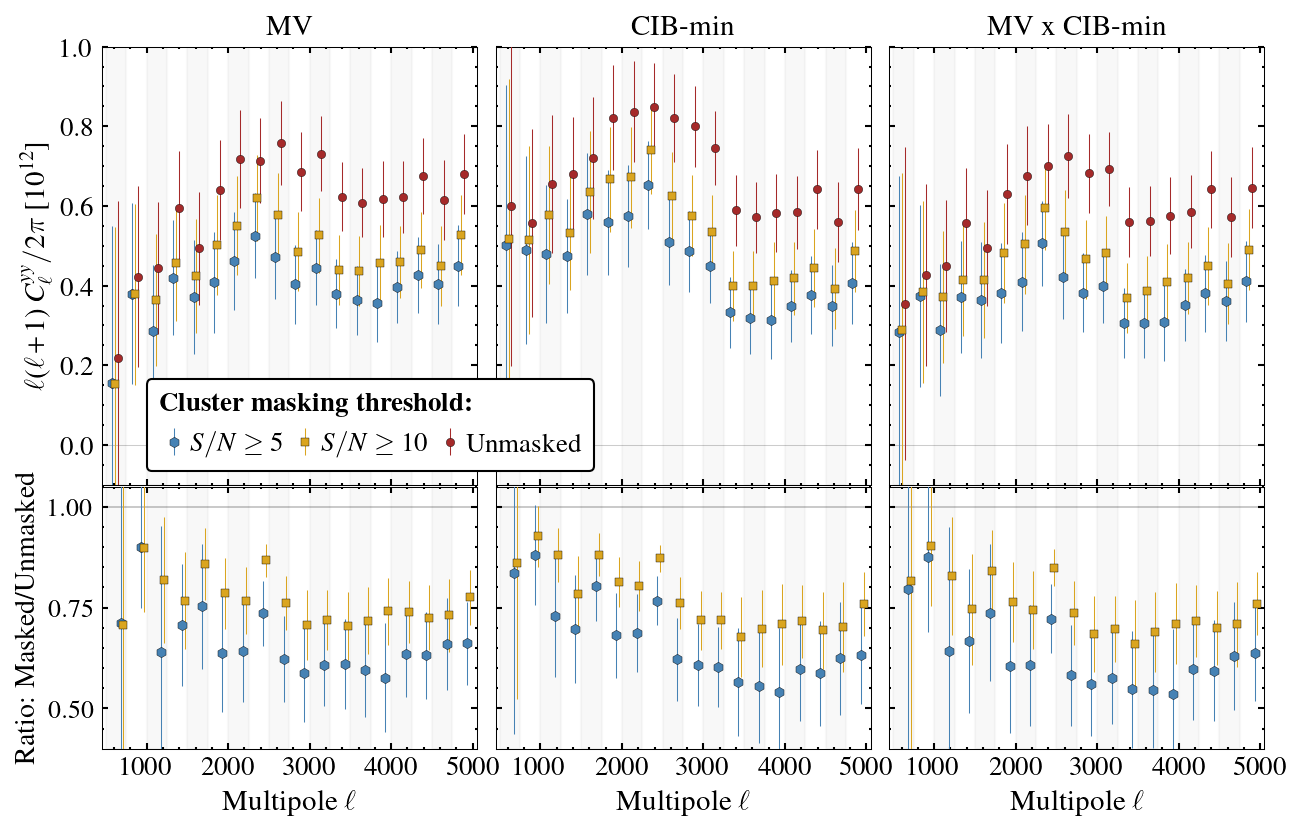

In [234]:
from scipy.optimize import curve_fit

fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
print(res_dic.keys())

m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())
also_include_ratio_plot = True
clf()
fsval = 14
if also_include_ratio_plot:
    tr, tc = 8, 3
    rspan = 5
    fig = figure(figsize = (10., 6.2))
else:
    tr, tc = 1, 3
    rspan = 1
    fig = figure(figsize = (10., 4.2))
subplots_adjust(wspace = 0.05, hspace = 0.02)
ymin, ymax = -0.1, 1.#2
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

#left panel - Final tSZ estimate for all ILC combinations with total error.
mkrval1, msval1 = '', 1.5
mkrval2, msval2 = '.', 1.5
mkrval3, msval3 = '.', 1.5
mkrval4, msval4 = '.', 1.5

ilc_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

#cluster_masking_snr_specs_dic = {4.5: ['steelblue', r'$S/N \ge 4.5$', 'h', 5.], 
cluster_masking_snr_specs_dic = {5.: ['steelblue', r'$S/N \ge 5$', 'h', 5.], 
                10.: ['goldenrod', r'$S/N \ge 10$', 's', 4.], 
                None: ['brown', r'Unmasked', 'o', 4.], 
               }

results_for_cr_dic = {}
for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):
    ##print(res_dic[m1m2].keys()); sys.exit()
    el_ = res_dic[m1m2]['els']
    cl_data_final = res_dic[m1m2]['data_final']
    cl_data_err = res_dic[m1m2]['data_error']
    data_final_cluster_masked_dic = res_dic[m1m2]['data_final_cluster_masked_dic']
    ##print(data_final_cluster_masked_dic.keys()); sys.exit()

    linds = np.where(el_<=lmax_for_plotting)[0]
    el_ = el_[linds]
    cl_data_err = cl_data_err[linds]
    dl_fac = el_ * (el_+1)/2/np.pi * mulfac
    
    ##print(tr, tc, m1m2cntr)
    ax = subplot2grid((tr, tc), (0, m1m2cntr), rowspan = rspan)
    xshiftval = -50.
    xshiftdeltaval = 35.
    lwval = 0.5
    curr_masked_plot_dic = {}
    for cluster_masking_snr in cluster_masking_snr_specs_dic:

        if cluster_masking_snr is None:
            curr_cl_data = cl_data_final
        else:
            curr_cl_data = data_final_cluster_masked_dic[cluster_masking_snr]

        curr_cl_data = curr_cl_data[linds]
        curr_masked_plot_dic[cluster_masking_snr] = curr_cl_data

        colorval, labval, mkrval, msval = cluster_masking_snr_specs_dic[cluster_masking_snr]
        errorbar(el_ + xshiftval, dl_fac * curr_cl_data, 
                 yerr = dl_fac * cl_data_err, 
                 color = colorval, mec = 'black', mew = 0.2, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )
        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)
    if show_error_decomposition:
        title(r'%s' %(ilc_specs_dic[m1m2][1]), fontsize = fsval)

    if also_include_ratio_plot:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 2:
        legfsval, leg_xloc, leg_yloc = fsval, -.65, 0.
        legfsval, leg_xloc, leg_yloc = fsval-1., -.75, 0.
        leg = legend(bbox_to_anchor = (leg_xloc, leg_yloc), loc = 4, 
               fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, 
               handlelength = 1., numpoints = 1, 
               title = r'{\bf Cluster masking threshold:}', title_fontsize = legfsval, 
               framealpha = 1.,
               )
        leg._legend_box.align = "left"
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)

    if also_include_ratio_plot:
        #ratio plot in the bottom now
        ax = subplot2grid((tr, tc), (rspan, m1m2cntr), rowspan = tr-rspan)
        baseline_cluster_masking_snr = None
        baseline_cl_data = curr_masked_plot_dic[baseline_cluster_masking_snr]
        for cluster_masking_snr in curr_masked_plot_dic:
            if cluster_masking_snr == baseline_cluster_masking_snr: continue
            curr_cl_data = curr_masked_plot_dic[cluster_masking_snr]
            colorval, labval, mkrval, msval = cluster_masking_snr_specs_dic[cluster_masking_snr]
            #plot( el_, curr_cl_data/baseline_cl_data, color = colorval, ls = '-')
            curr_ratio = curr_cl_data/baseline_cl_data
            ####curr_ratio_error = dl_fac * cl_data_err
            curr_ratio_with_low_error = (curr_cl_data - cl_data_err)/(baseline_cl_data - cl_data_err)
            curr_ratio_with_high_error = (curr_cl_data + cl_data_err)/(baseline_cl_data + cl_data_err)
            yminval, ymaxval = 0.4, 1.05
            ylabval = r'Ratio: Masked/Unmasked'
            if (0):
                curr_ratio = 1./curr_ratio
                curr_ratio_with_low_error = 1./curr_ratio_with_low_error
                curr_ratio_with_high_error = 1./curr_ratio_with_high_error
                yminval, ymaxval = 0.95, 2.
                ylabval = r'Ratio: Unmasked/masked'
            curr_ratio_error = (curr_ratio_with_low_error-curr_ratio_with_high_error)
            """
            if (0): #fit for tilt
                x, y = el_, curr_ratio
                m, c = np.polyfit(x, y, 1)
                print(m, c)
                yfit = m * x + c
                plot(el_, yfit, color = colorval, lw = 2.)
            if (1):
                linds = np.where( el_>=2500)[0]
                x, y, yerr = el_[linds], curr_ratio[linds], curr_ratio_error[linds]
                def linear_function(x, slope, intercept):
                    return slope * x + intercept
                
                popt, pcov = curve_fit(linear_function, x, y, sigma=yerr)
                print(popt)
                yfit = linear_function(x, popt[0], popt[1])
                plot(el_[linds], yfit, color = colorval, lw = 2.)
            if (0):
                x, y, yerr = el_, curr_ratio, curr_ratio_error
                def fit_function(x, a, b, c, x_norm = 3000): return a + b * (x/x_norm)**-c
                #def fit_function(x, a, b, c): return a + b * (x)**-c
                
                popt, pcov = curve_fit(linear_function, x, y, sigma=yerr)
                yfit = fit_function(x, popt[0], popt[1], popt[1])
                #print(yfit)
                plot(el_, yfit, color = colorval, lw = 2.)

            axhline(np.mean(curr_ratio), color = colorval, )
            if (1):
                tmpinds = np.where( (el_>=2800) & (el_<=3200) )[0]
                #tmpinds = np.argmin( abs(el_-3000) )
                print(cluster_masking_snr, el_[tmpinds], np.mean(el_[tmpinds]), 
                      np.mean(1/curr_ratio[tmpinds]), '+/-', np.mean(curr_ratio_error[tmpinds]),
                      )##; sys.exit()
            """
            errorbar(el_ + xshiftval, curr_ratio, 
                     #yerr = dl_fac * cl_data_err, 
                     #yerr = [curr_ratio_with_low_error, curr_ratio_with_high_error], 
                     yerr = curr_ratio_error, 
                     color = colorval, mec = 'black', mew = 0.2, 
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval,
                     elinewidth = lwval, ecolor = colorval, 
                     zorder = 10000,
                    )
            xshiftval += xshiftdeltaval

        xlabel(r'Multipole $\ell$', fontsize = fsval)
        if m1m2cntr == 0:
            ylabel(ylabval, fontsize = fsval-0.5)
        else:
            setp(ax.get_yticklabels(), visible=False)
        xlim(xmin, xmax); ylim(yminval, ymaxval)
        axhline(1., lw = 0.2)
        ax = make_ver_shades(ax, el_)
        ax = format_axis(ax, fsval-1., fsval-1.5)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

        
plname = 'plots/ymap_spectra_data_cluster_masking'
plname = '%s.pdf' %(plname)
#plname = '%s.png' %(plname)
savefig(plname, dpi = 200.)
show()


# tSZ for different source masking thresholds

1 3 0
1 3 1
1 3 2


<Figure size 900x600 with 0 Axes>

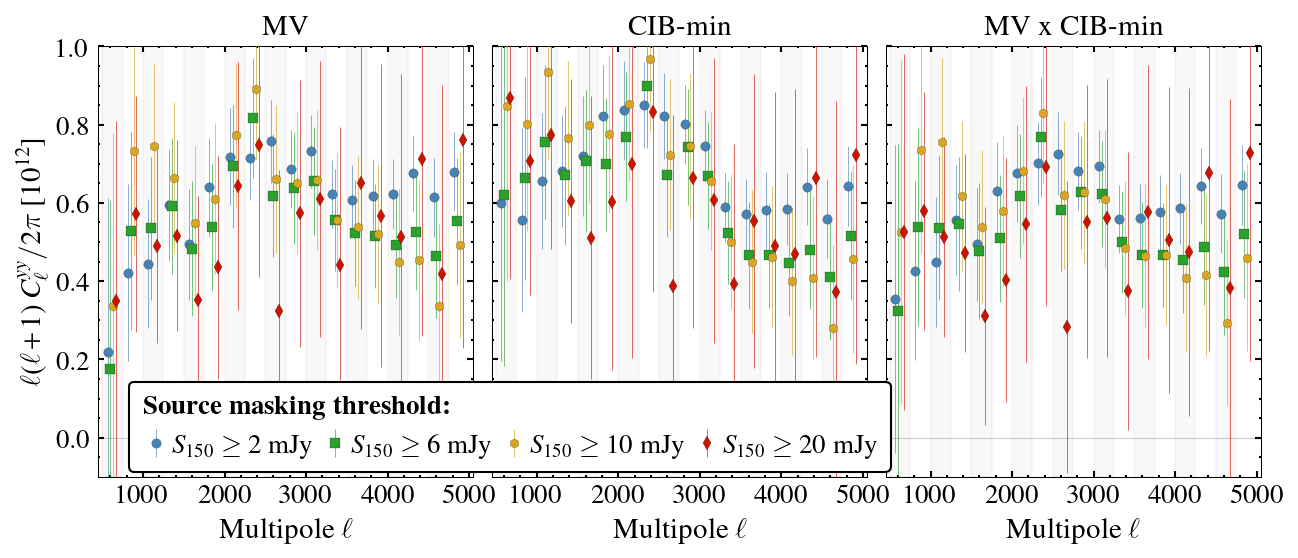

In [220]:
fname1 = 'results/100d_tsz_final_estimate.npy'
fname2 = 'results/100d_tsz_final_estimate_6mjy.npy'
fname3 = 'results/100d_tsz_final_estimate_10mjy.npy'
fname4 = 'results/100d_tsz_final_estimate_20mjy.npy'

fname_dic = {2: fname1, 6: fname2, 10: fname3, 20: fname4}

pl_dic = {}
for source_masking in fname_dic:
    curr_fname = fname_dic[source_masking]
    curr_res_dic = np.load(curr_fname, allow_pickle=True).item()
    m1_m2_ilc_comb_arr_to_plot = list(curr_res_dic.keys())
    pl_dic[source_masking] = {}
    for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):
        el_ = curr_res_dic[m1m2]['els']
        cl_data_final = curr_res_dic[m1m2]['data_final']
        ##print(cl_data_final)
        cl_data_err = curr_res_dic[m1m2]['data_error']
        linds = np.where(el_<=lmax_for_plotting)[0]
        pl_dic[source_masking][m1m2] = [el_[linds], cl_data_final[linds], cl_data_err[linds]]
#sys.exit()

clf()
fsval = 14
also_include_ratio_plot = False
if also_include_ratio_plot:
    tr = 8
    rspan = 5
    fig = figure(figsize = (10., 6.6))
else:
    tr = 1
    rspan = 1
    fig = figure(figsize = (10., 3.8))
subplots_adjust(wspace = 0.05, hspace = 0.02)
ymin, ymax = -0.1, 1.#2
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

ilc_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

source_masking_specs_dic = {2.: ['steelblue', 'black', r'$S_{150} \ge 2$ mJy', 'o', 4.], 
                6.: ['tab:green', 'black', r'$S_{150} \ge 6$ mJy', 's', 4.], 
                10.: ['goldenrod', 'black', r'$S_{150} \ge 10$ mJy', 'h', 4.], 
                20.: ['#CD1300', 'black', r'$S_{150} \ge 20$ mJy', 'd', 4.], 
               }

for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):

    print(tr, tc, m1m2cntr)
    ax = subplot2grid((tr, tc), (0, m1m2cntr), rowspan = rspan)
    xshiftval = -60.
    xshiftdeltaval = 35.
    lwval = 0.5
    curr_masked_plot_dic = {}
    for source_masking in pl_dic:

        el_, curr_cl_data_final, curr_cl_data_err = pl_dic[source_masking][m1m2]
        dl_fac = el_ * (el_+1)/2/np.pi * mulfac
        curr_masked_plot_dic[source_masking] = [dl_fac * curr_cl_data_final, dl_fac * curr_cl_data_err]
        colorval, mec, labval, mkrval, msval = source_masking_specs_dic[source_masking]
        msval, lwval, mew = msval+0.5, 0.3, 0.1
        errorbar(el_ + xshiftval, dl_fac * curr_cl_data_final, 
                 yerr = dl_fac * curr_cl_data_err, 
                 color = colorval, mec = mec, mew = mew, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )
        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)
    if show_error_decomposition:
        title(r'%s' %(ilc_specs_dic[m1m2][1]), fontsize = fsval)

    if also_include_ratio_plot:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 2:
        legfsval, leg_xloc, leg_yloc = fsval, 0.2, -0.02
        legfsval, leg_xloc, leg_yloc = fsval-1, 0.05, -0.02
        leg = legend(bbox_to_anchor = (leg_xloc, leg_yloc), loc = 4, 
               fontsize = legfsval, ncol = len(pl_dic), handletextpad = 0.1, columnspacing = 0.3, 
               handlelength = 1., numpoints = 1, 
               title = r'{\bf Source masking threshold:}', title_fontsize = legfsval, 
               framealpha = 1.,
               )
        leg._legend_box.align = "left"
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)

    if also_include_ratio_plot:
        #ratio plot in the bottom now
        ax = subplot2grid((tr, tc), (rspan, m1m2cntr), rowspan = tr-rspan)
        baseline_masking = 2.0
        baseline_cl_data, baseline_cl_data_err = curr_masked_plot_dic[baseline_masking]
        for source_masking in curr_masked_plot_dic:
            if source_masking == baseline_masking: continue
            curr_cl_data, curr_cl_data_err = curr_masked_plot_dic[source_masking]
            colorval, mec, labval, mkrval, msval = source_masking_specs_dic[source_masking]
            errorbar(el_ + xshiftval, curr_cl_data/baseline_cl_data, 
                     yerr = curr_cl_data_err, 
                     color = colorval, mec = mec, mew = 0.2, 
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval,
                     elinewidth = lwval, ecolor = colorval, 
                     zorder = 10000,
                    )
            xshiftval += xshiftdeltaval

        xlabel(r'Multipole $\ell$', fontsize = fsval)
        if m1m2cntr == 0:
            ylabel(r'Ratio: Masked/Unmasked', fontsize = fsval-0.5)
        else:
            setp(ax.get_yticklabels(), visible=False)
        xlim(xmin, xmax); ylim(0.4, 1.05)
        axhline(1., lw = 0.5)
        ax = make_ver_shades(ax, el_)
        ax = format_axis(ax, fsval-1., fsval-1.5)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        
plname = 'plots/ymap_spectra_data_source_masking'
plname = '%s.pdf' %(plname)
#plname = '%s.png' %(plname)
savefig(plname, dpi = 200.)
show()


# tSZ power spectrum: Combined plot for both cluster and source masking

dict_keys([('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')])
2 3 0
2 3 1
2 3 2


<Figure size 900x600 with 0 Axes>

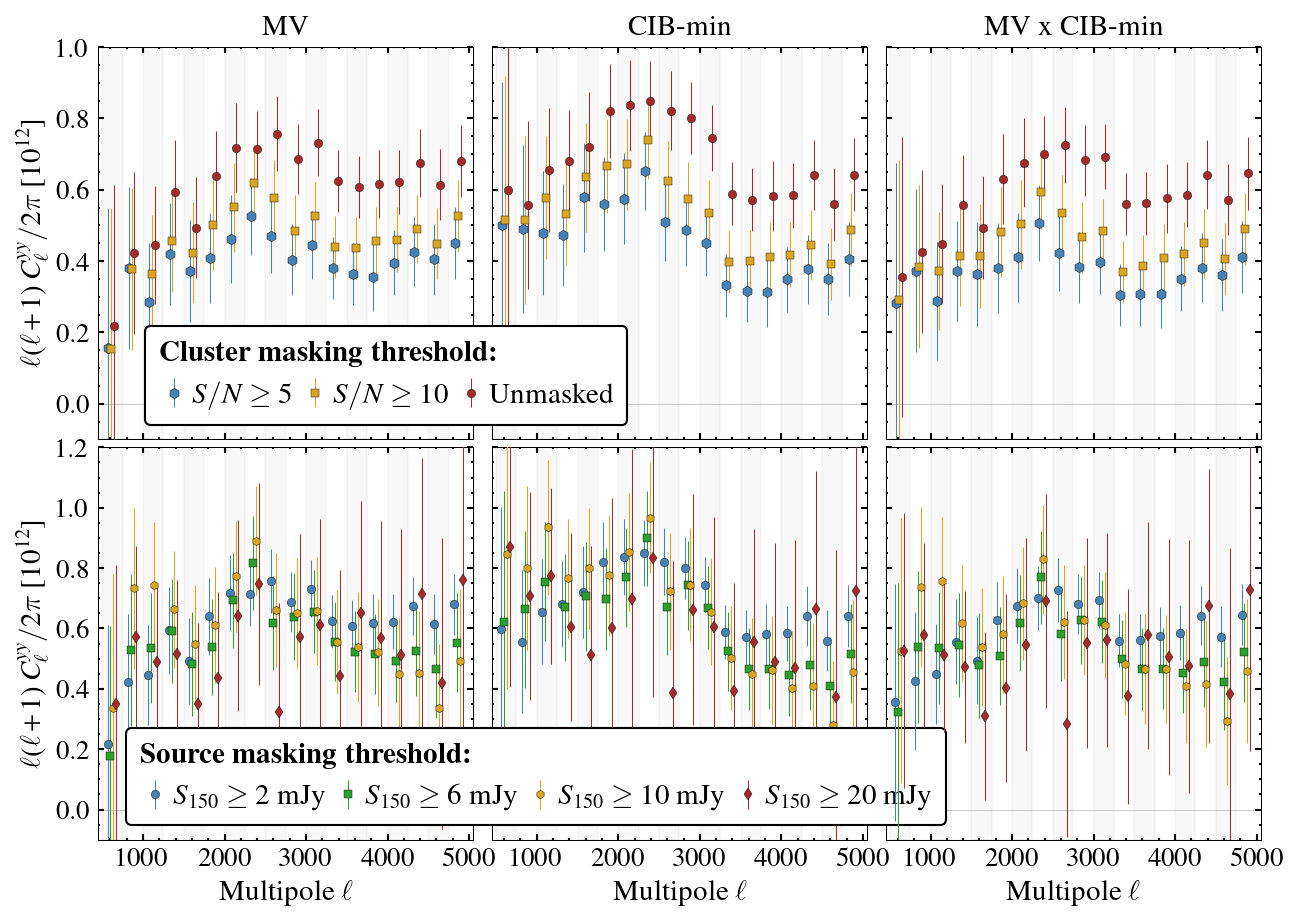

In [101]:
#cluster masking results
fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
print(res_dic.keys())
m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())


#source masking results
fname1 = 'results/100d_tsz_final_estimate.npy'
fname2 = 'results/100d_tsz_final_estimate_6mjy.npy'
fname3 = 'results/100d_tsz_final_estimate_10mjy.npy'
fname4 = 'results/100d_tsz_final_estimate_20mjy.npy'

fname_dic = {2: fname1, 6: fname2, 10: fname3, 20: fname4}

pl_dic = {}
for source_masking in fname_dic:
    curr_fname = fname_dic[source_masking]
    curr_res_dic = np.load(curr_fname, allow_pickle=True).item()
    m1_m2_ilc_comb_arr_to_plot = list(curr_res_dic.keys())
    pl_dic[source_masking] = {}
    for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):
        el_ = curr_res_dic[m1m2]['els']
        cl_data_final = curr_res_dic[m1m2]['data_final']
        ##print(cl_data_final)
        cl_data_err = curr_res_dic[m1m2]['data_error']
        linds = np.where(el_<=lmax_for_plotting)[0]
        pl_dic[source_masking][m1m2] = [el_[linds], cl_data_final[linds], cl_data_err[linds]]


clf()
fsval = 14
tr = 2
rspan = 1
fig = figure(figsize = (10., 7.))
subplots_adjust(wspace = 0.05, hspace = 0.02)
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

ilc_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

#cluster_masking_snr_specs_dic = {4.5: ['steelblue', r'$S/N \ge 4.5$', 'h', 5.], 
cluster_masking_snr_specs_dic = {5.: ['steelblue', r'$S/N \ge 5$', 'h', 5.], 
                10.: ['goldenrod', r'$S/N \ge 10$', 's', 4.], 
                None: ['brown', r'Unmasked', 'o', 4.], 
               }

source_masking_specs_dic = {2.: ['steelblue', 'black', r'$S_{150} \ge 2$ mJy', 'o', 4.], 
                6.: ['tab:green', 'black', r'$S_{150} \ge 6$ mJy', 's', 4.], 
                10.: ['goldenrod', 'black', r'$S_{150} \ge 10$ mJy', 'h', 4.], 
                20.: ['brown', 'black', r'$S_{150} \ge 20$ mJy', 'd', 4.], 
               }


for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):
    ##print(res_dic[m1m2].keys()); sys.exit()
    el_ = res_dic[m1m2]['els']
    cl_data_final = res_dic[m1m2]['data_final']
    cl_data_err = res_dic[m1m2]['data_error']
    data_final_cluster_masked_dic = res_dic[m1m2]['data_final_cluster_masked_dic']
    ##print(data_final_cluster_masked_dic.keys()); sys.exit()

    linds = np.where(el_<=lmax_for_plotting)[0]
    el_ = el_[linds]
    cl_data_err = cl_data_err[linds]
    dl_fac = el_ * (el_+1)/2/np.pi * mulfac
    
    print(tr, tc, m1m2cntr)
    ymin, ymax = -0.1, 1.#2
    ax = subplot2grid((tr, tc), (0, m1m2cntr), rowspan = rspan)
    xshiftval = -50.
    xshiftdeltaval = 35.
    lwval = 0.5
    curr_masked_plot_dic = {}
    for cluster_masking_snr in cluster_masking_snr_specs_dic:

        if cluster_masking_snr is None:
            curr_cl_data = cl_data_final
        else:
            curr_cl_data = data_final_cluster_masked_dic[cluster_masking_snr]

        curr_cl_data = curr_cl_data[linds]
        curr_masked_plot_dic[cluster_masking_snr] = curr_cl_data

        colorval, labval, mkrval, msval = cluster_masking_snr_specs_dic[cluster_masking_snr]
        errorbar(el_ + xshiftval, dl_fac * curr_cl_data, 
                 yerr = dl_fac * cl_data_err, 
                 color = colorval, mec = 'black', mew = 0.2, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )
        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)
    if show_error_decomposition:
        title(r'%s' %(ilc_specs_dic[m1m2][1]), fontsize = fsval)

    setp(ax.get_xticklabels(), visible=False)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 2:
        legfsval = fsval
        leg = legend(bbox_to_anchor = (-.65, 0.), loc = 4, 
               fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, 
               handlelength = 1., numpoints = 1, 
               title = r'{\bf Cluster masking threshold:}', title_fontsize = legfsval, 
               framealpha = 1.,
               )
        leg._legend_box.align = "left"
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)


    #source masking now
    ymin, ymax = -0.1, 1.2
    ax = subplot2grid((tr, tc), (1, m1m2cntr), rowspan = rspan)
    xshiftval = -60.
    xshiftdeltaval = 35.
    lwval = 0.5
    curr_masked_plot_dic = {}
    for source_masking in pl_dic:

        el_, curr_cl_data_final, curr_cl_data_err = pl_dic[source_masking][m1m2]
        dl_fac = el_ * (el_+1)/2/np.pi * mulfac
        curr_masked_plot_dic[source_masking] = [dl_fac * curr_cl_data_final, dl_fac * curr_cl_data_err]
        colorval, mec, labval, mkrval, msval = source_masking_specs_dic[source_masking]
        errorbar(el_ + xshiftval, dl_fac * curr_cl_data_final, 
                 yerr = dl_fac * curr_cl_data_err, 
                 color = colorval, mec = mec, mew = 0.2, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )
        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)
    if show_error_decomposition:
        title(r'%s' %(ilc_specs_dic[m1m2][1]), fontsize = fsval)

    if also_include_ratio_plot:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)

    
    if m1m2cntr == 2:
        legfsval = fsval
        leg = legend(bbox_to_anchor = (.2, 0.), loc = 4, 
               fontsize = legfsval, ncol = len(pl_dic), handletextpad = 0.1, columnspacing = 0.3, 
               handlelength = 1., numpoints = 1, 
               title = r'{\bf Source masking threshold:}', title_fontsize = legfsval, 
               framealpha = 1.,
               )
        leg._legend_box.align = "left"
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)


plname = 'plots/ymap_spectra_data_cluster_source_masking'
plname = '%s.pdf' %(plname)
#plname = '%s.png' %(plname)
savefig(plname, dpi = 200.)
show()


dict_keys([('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')])


<Figure size 900x600 with 0 Axes>

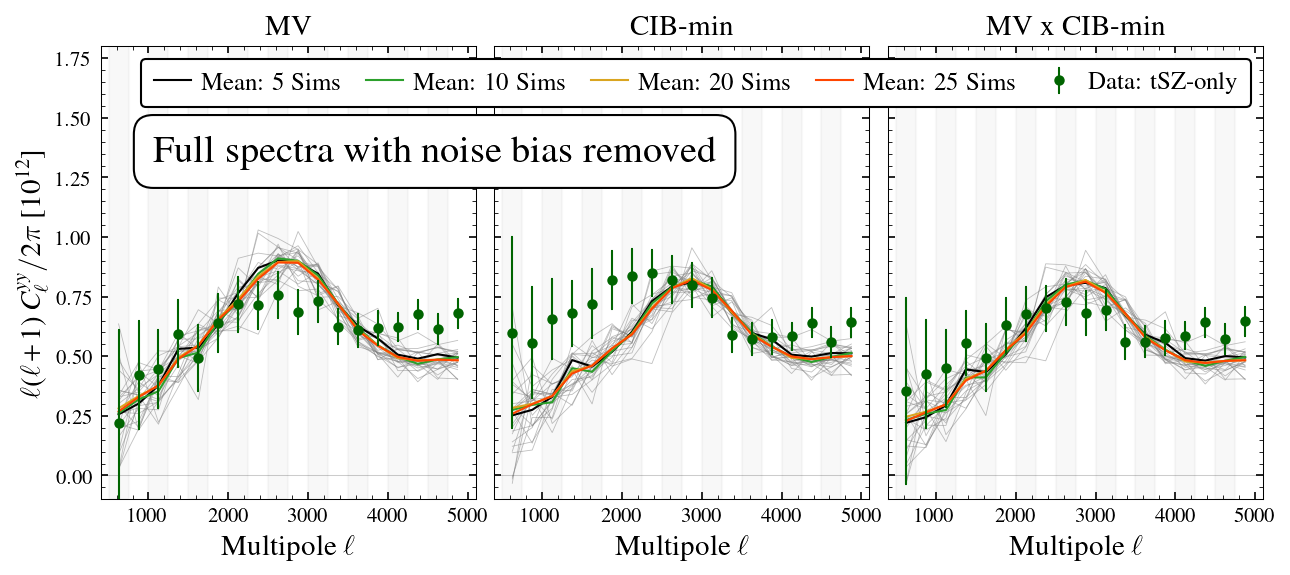

In [149]:
fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
print(res_dic.keys())

m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())

show_error_decomposition = False ##True

clf()
xmin, xmax = 400., 5100.
lmax_for_plotting = 5000.
capsizeval = 0.5
mulfac = 1e12
fsval = 14
tr, tc = 1, 3
fig = figure(figsize = (10., 4))
subplots_adjust(wspace = 0.05, hspace = 0.05)

yscaleval = None
if yscaleval is None:
    #ymin, ymax = -0.1, 2.2 ##2.2 #1.1
    ymin, ymax = -0.1, 1.4
    ymin, ymax = -0.1, 1.8 ##2.2 #1.1
elif yscaleval == 'log':
    ymin, ymax = 0.05, 20.


#Three panels - Total data, total sims w/o tSZ, final tSZ estimate, and all the individual signals for each ILC combinations.
pl_specs_dic = {
                'cib_tweaked': ['orangered', r'CIB', 1., 0.15], 
                'cib_tweaked_spt_only': ['orangered', r'CIB', 1., 0.15], 
                'cib_tweaked_spt_only_max_tweak_0.2': ['orangered', r'CIB', 1., 0.15], 
                'cib_tweaked_max_tweak_0.2': ['orangered', r'CIB', 1., 0.15], 
                'rad_tweaked': ['royalblue', r'Radio', 1., 0.2], 
                'rad_tweaked_spt_only_max_tweak_0.2': ['navy', r'Radio', 1., 0.2], 
                'rad_tweaked_max_tweak_0.2': ['navy', r'Radio', 1., 0.2], 
                'cmb': ['goldenrod', r'CMB', 1., 0.6],
                'cmb_withspiretcalerror': ['goldenrod', r'CMB', 1., 0.6],
                'ksz': ['hotpink', r'kSZ', 1., 0.6],
                'total': ['black', r'Total', 1., 0.8],
               }

title_dic = {('ymv', 'ymv'): r'MV', 
                ('ycibfree', 'ycibfree'): r'CIB-min', 
                ('ycibfree', 'ymv'): r'MV x CIB-min',
               }

for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):

    ax = subplot2grid((tr, tc), (0, m1m2cntr), yscale = yscaleval)
        

    ##print(res_dic[m1m2].keys())
    el_ = res_dic[m1m2]['els']
    el_ori = np.copy( el_ )
    cl_data= res_dic[m1m2]['data'] * mulfac
    cl_sim = res_dic[m1m2]['sim'] * mulfac
    cl_data_final = res_dic[m1m2]['data_final'] * mulfac
    cl_data_err = res_dic[m1m2]['data_error'] * mulfac
    cl_data_err = np.sqrt( np.diag(res_dic[m1m2]['stat_cov_non_gau']) ) * mulfac    

    linds = np.where(el_<=lmax_for_plotting)[0]
    el_, cl_data, cl_sim, cl_data_final, cl_data_err = el_[linds], cl_data[linds], cl_sim[linds], cl_data_final[linds], cl_data_err[linds]
    dl_fac = el_ * (el_+1)/2/np.pi 

    #plot sims
    colorval, labval, lwval = 'black', r'Sim (no-tSZ)', 1.
    #plot( el_, dl_fac * cl_sim, color = colorval, label = labval, lw = lwval, zorder = 50)
    if (1):
        if (0):
            cl_sim_arr = res_dic[m1m2]['cl_for_sub_arr'] * mulfac
            figtextval = 'Bundle0 x Bundle1: No noise bias'
        
        if (1):
            cl_arr_sim_tsz, cl_mean_sim_tsz = res_dic[m1m2]['cl_arr_sim_tsz']
            cl_arr_sim_noise, cl_mean_sim_noise = res_dic[m1m2]['noise']
            cl_arr_sim_all_signals_full, cl_mean_sim_all_signals_full = res_dic[m1m2]['cl_sim_all_signals_full']
            cl_arr_sim_all_signals_full = cl_arr_sim_all_signals_full - cl_arr_sim_noise - cl_arr_sim_tsz
            cl_sim_arr = cl_arr_sim_all_signals_full * mulfac
            ##print(cl_sim_arr[3])
            figtextval = 'Full spectra with noise bias removed'
            
        if (0):
            cl_arr_sim_tsz, cl_mean_sim_tsz = res_dic[m1m2]['cl_arr_sim_tsz']
            cl_arr_sim_noise, cl_mean_sim_noise = res_dic[m1m2]['noise']
            cl_arr_for_non_gau_cov = res_dic[m1m2]['cl_arr_for_non_gau_cov'][:25]
            cl_sim_arr = cl_arr_for_non_gau_cov - cl_arr_sim_noise - cl_arr_sim_tsz
            cl_sim_arr = cl_sim_arr * mulfac
            ##print(cl_sim_arr[3]); ##sys.exit()
            
            
        
        cl_sim_arr = cl_sim_arr[:, linds]
        for cl_ in cl_sim_arr:
            plot( el_, dl_fac * cl_, color = 'gray', lw = 0.4, alpha = 0.5)
        
        
        if (0):
            violin_width = np.diff(el_)[0]
            for lcntr, tmpel in enumerate(el_):
                curr_cl_bin = cl_sim_arr[:, lcntr]
                #print( tmpel, np.std(curr_cl_bin) * dl_fac[lcntr], cl_data_err[lcntr] * dl_fac[lcntr] ); 
                violins = violinplot([dl_fac[lcntr] * curr_cl_bin], [tmpel], widths = violin_width, showextrema = False, showmeans=False, points = 100)
                for pc in violins['bodies']:        
                    pc.set_facecolor('None'); pc.set_edgecolor('black'); pc.set_alpha(1.); pc.set_linestyle('-'); pc.set_linewidth(0.7)
        
        tmpnosims = 5
        cl_sim_arr_mean = np.mean(cl_sim_arr[:tmpnosims], axis = 0)
        plot( el_, dl_fac * cl_sim_arr_mean, color = 'black', lw = 1., label = r'Mean: %s Sims' %(tmpnosims))
        tmpnosims = 10
        cl_sim_arr_mean = np.mean(cl_sim_arr[:tmpnosims], axis = 0)
        plot( el_, dl_fac * cl_sim_arr_mean, color = 'tab:green', lw = 1., label = r'Mean: %s Sims' %(tmpnosims))
        tmpnosims = 20
        cl_sim_arr_mean = np.mean(cl_sim_arr[:tmpnosims], axis = 0)
        plot( el_, dl_fac * cl_sim_arr_mean, color = 'goldenrod', lw = 1., label = r'Mean: %s Sims' %(tmpnosims))
        tmpnosims = 25
        cl_sim_arr_mean = np.mean(cl_sim_arr[:tmpnosims], axis = 0)
        plot( el_, dl_fac * cl_sim_arr_mean, color = 'orangered', lw = 1., label = r'Mean: %s Sims' %(tmpnosims))

        if (0):
            tmpnosims = 25
            #cl_sim_arr = res_dic[m1m2]['cl_arr_for_non_gau_cov'] * mulfac
            cl_sim_arr = (res_dic[m1m2]['cl_arr_for_non_gau_cov'] - res_dic[m1m2]['cl_arr_sim_tsz'][1] ) * mulfac
            cl_sim_arr = cl_sim_arr[:, linds]
            cl_sim_arr = cl_sim_arr[:tmpnosims]
            cl_sim_arr_mean = np.mean(cl_sim_arr, axis = 0)
            for cl_ in cl_sim_arr:
                plot( el_, dl_fac * cl_, color = 'crimson', lw = 0.2, alpha = 0.5)
            plot( el_, dl_fac * cl_sim_arr_mean, color = 'red', lw = 2.)

            if (1):
                violin_width = np.diff(el_)[0]
                for lcntr, tmpel in enumerate(el_):
                    curr_cl_bin = cl_sim_arr[:, lcntr]
                    #print( tmpel, np.std(curr_cl_bin) * dl_fac[lcntr], cl_data_err[lcntr] * dl_fac[lcntr] ); 
                    violins = violinplot([dl_fac[lcntr] * curr_cl_bin], [tmpel], widths = violin_width, showextrema = False, showmeans=False, points = 100)
                    for pc in violins['bodies']:        
                        pc.set_facecolor('None'); pc.set_edgecolor('black'); pc.set_alpha(1.); pc.set_linestyle('-'); pc.set_linewidth(0.7)
                    
    #plot data final
    colorval, labval, mkrval, msval, lwval = 'darkgreen', r'Data: tSZ-only', 'o', 4., 1.
    errorbar(el_, dl_fac * cl_data_final, 
             yerr = dl_fac * cl_data_err, 
             color = colorval, 
             ls ='None', 
             label = labval, 
             capsize = capsizeval, 
             marker = mkrval, ms = msval,
             elinewidth = lwval, 
             zorder = 100,
            )    

    if m1m2cntr == 2:
        legfsval = fsval - 2. #0.5
        legend(loc = 1, bbox_to_anchor = (1., 1.),
               fontsize = legfsval, ncol = 5, handletextpad = 0.4, columnspacing = 1., 
               handlelength = 1.5, numpoints = 1,
              framealpha = 1.)

    #shades
    ax = make_ver_shades(ax, el_)
    #ax = format_axis(ax, fsval, fsval)
    
    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
        figtext(0.16, 0.69, figtextval, fontsize = 18.5, zorder = 100, 
                bbox=dict(facecolor='white',  # Background color of the box
                  alpha=1.,             # Transparency of the box
                  boxstyle='round,pad=0.5'),
               )
    else:
        setp(ax.get_yticklabels(), visible=False)
    if show_error_decomposition:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    xlim(xmin, xmax); ylim(ymin, ymax)
    
show()



# Fit Agora tSZ

/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_14477/2658027490.py:104: RuntimeWarning: invalid value encountered in true_divide
  agora_cl_yy = agora_dl_yy / agora_dl_fac


('ymv', 'ymv')
dict_keys([4.5, 20.0, 'spt3g_1920_lensing_mask'])
('ymv', 'ymv') 9.521690389740442
1.137 18.006028344907275 0.06875406513506266 0.05753697231313537
('ycibfree', 'ycibfree')
dict_keys([4.5, 20.0, 'spt3g_1920_lensing_mask'])
('ycibfree', 'ycibfree') 9.347357329830437
1.087 16.89784271067736 0.07045043782255633 0.0582050383363204
('ycibfree', 'ymv')
dict_keys([4.5, 20.0, 'spt3g_1920_lensing_mask'])
('ycibfree', 'ymv') 9.094413428588334
1.09 16.85805367578179 0.07031675075919197 0.05899829603839768


<Figure size 900x600 with 0 Axes>

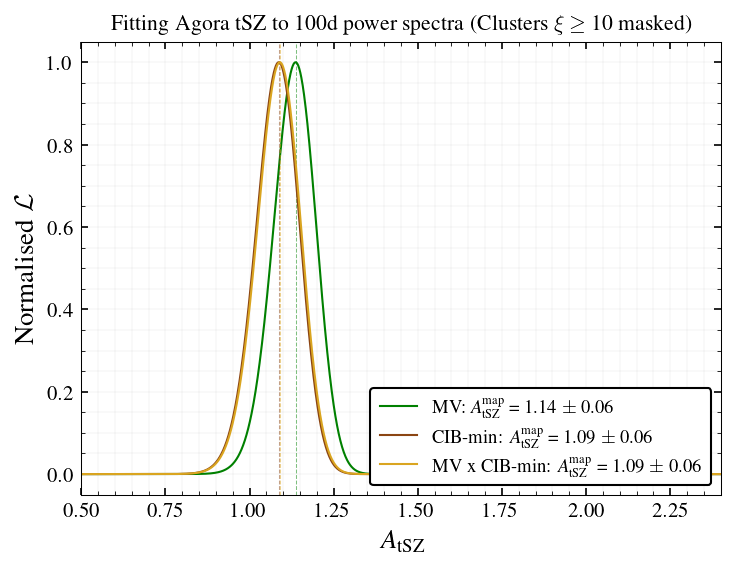

SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [460]:
"""
import numpy as np
from pylab import *

pl_specs_dic = {('ymv', 'ymv'): ['darkgreen', r'MV', 'o', 3], 
                ('ycibfree', 'ycibfree'): ['darkred', r'CIB-min', 'd', 3], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', 'h', 3],
               }

fname = 'results/100d_tsz_final_estimate_for_CR.npy'
res_dic = np.load(fname, allow_pickle=True).item()
ymin, ymax = -0.1, 1.
xmin, xmax = -100., 5100.

if (0):
    for m1m2 in res_dic:

        print( m1m2 )
        els = res_dic[m1m2]['els']
        dl_fac = els * (els+1)/2/np.pi
        cl_data_final = res_dic[m1m2]['bandpower']
        cl_data_err = res_dic[m1m2]['bandpower_error']
        cl_tot_cov = res_dic[m1m2]['cov']


        colorval, labval, mkrval, msval = pl_specs_dic[m1m2]
        lwval = 0.8
        errorbar(el_, dl_fac * cl_data_final, 
                 yerr = dl_fac * cl_data_err, 
                 color = colorval, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval,
                )

xlabel(r'Multipole $\ell$', fontsize = fsval)
ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
xlim(xmin, xmax); ylim(ymin, ymax)
    
if (1):
    delta_l = 250
    lmin, lmax = 500, 7000
    return_dl = False
    mdpl2_cl_tsz_150 = mdpl2_cl_dic['tsz'][(150, 150)]
    mdpl2_cl_yy = mdpl2_cl_tsz_150 / (tsz_150_compton_y_fac**2.) 
    plot(tmpel_, tmp_dl_fac * mdpl2_cl_yy, color = 'gray', alpha = 0.5, label = r'Unbinned')    
    tmpel_ = np.arange( len( mdpl2_cl_yy ) )
    tmp_dl_fac = tmpel_ * (tmpel_+1) / 2/ np.pi

    curr_el, curr_cl, bpwf = tools.perform_binning(tmpel_, mdpl2_cl_yy, delta_el = delta_l, return_dl = return_dl, lmin = lmin, lmax = lmax)
    print(bpwf)
    
    curr_dl_fac = curr_el * (curr_el+1)/2/np.pi
    plot(curr_el, curr_dl_fac * curr_cl, marker = 'o', ls = 'None', color = 'orangered', label = r'Binned with BPWF') 
    

    elbinned_v2, mdpl2_cl_yy_binned_v2 = tools.perform_binning_simple(tmpel_, mdpl2_cl_yy, delta_el = delta_l, lmin = lmin, lmax = lmax)
    tmp_dl_fac_binned_v2 = elbinned_v2 * (elbinned_v2+1)/2/np.pi
    plot(elbinned_v2, tmp_dl_fac_binned_v2 * mdpl2_cl_yy_binned_v2, marker = 'o', ls = 'None', color = 'black', label = r'Simple mean in each bin')

legend(loc = 4, fontsize = 10)
xlim(lmin-10, lmax+10)
show()

#leff
for liter in range( len(curr_el) ):
    print(liter)
    print(curr_el[liter], bpwf[liter,:] @ tmpel_)


#plot windows
clf()
for liter in range( len(curr_el) ):
    plot(bpwf[liter,:])
#xlim(0, max(mkk_els))
#title(r'P$_{bl}$: Weight needed for each finer elbins to produce coarser binned spectrum (Simple average)', fontsize = 8)
xlabel(r'Multipole $\ell$', fontsize = fsval)
ylabel(r'$W_{\ell}$', fontsize = fsval)
xlim(lmin-10, lmax+10)
show()
"""

import numpy as np
from pylab import *

pl_specs_dic = {('ymv', 'ymv'): ['darkgreen', r'MV', 'o', 3],
                ('ycibfree', 'ycibfree'): ['darkred', r'CIB-min', 'd', 3],
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', 'h', 3],
               }
ymin, ymax = -0.1, 1.
xmin, xmax = -100., 5100.

fname = 'results/100d_tsz_final_estimate.npy'
res_dic = np.load(fname, allow_pickle=True).item()
mulfac = 1e12

spt3g_tsz_150_scalefac = -2.6363439931018213
agora_template_fname = 'data/agora_spt3g/dls_tsz150_tsz150.txt'
agora_els, agora_dl_tsz = np.loadtxt(agora_template_fname, unpack = True )
agora_dl_yy = agora_dl_tsz / (spt3g_tsz_150_scalefac**2.)
agora_dl_fac = agora_els * (agora_els+1)/2/np.pi
agora_cl_yy = agora_dl_yy / agora_dl_fac
agora_cl_yy[np.isnan(agora_cl_yy)] = 0.

"""
lmin, lmax = 500, 7000
return_dl = False
delta_l = 250
agora_els_binned, agora_cl_yy_binned, bpwf = tools.perform_binning(agora_els, agora_cl_yy, delta_el = delta_l, return_dl = return_dl, lmin = lmin, lmax = lmax)
print( bpwf.shape )
if (1):
    curr_dl_fac_binned = agora_els_binned * (agora_els_binned+1)/2/np.pi
    plot(agora_els, agora_dl_yy) 
    plot(agora_els_binned, curr_dl_fac_binned * agora_cl_yy_binned, marker = 'o', ls = 'None', color = 'orangered', label = r'Binned with BPWF') 
    show(); sys.exit()

"""
total_bins = len(el_)
total_els = len(agora_els)
bpwf = np.zeros( (total_bins, total_els) )
for liter in range(total_bins):
    el1, el2 = el_[liter] - delta_l/2, el_[liter] + delta_l/2
    curr_linds = np.where( (agora_els>=el1) & (agora_els<el2) )
    bpwf[liter, curr_linds] = 1/delta_l

if (0): #plot windows
    clf()
    for liter in range( len(el_) ):
        plot(bpwf[liter,:])
    sys.exit()


agora_els_binned, agora_cl_yy_binned = [], []
for liter in range( len(el_) ):
    agora_els_binned.append( bpwf[liter,:] @ agora_els )
    agora_cl_yy_binned.append( bpwf[liter,:] @ agora_cl_yy )    
agora_els_binned = np.asarray( agora_els_binned )
agora_cl_yy_binned = np.asarray( agora_cl_yy_binned )

if (0):
    curr_dl_fac_binned = agora_els_binned * (agora_els_binned+1)/2/np.pi
    plot(agora_els, agora_dl_yy) 
    plot(agora_els_binned, curr_dl_fac_binned * agora_cl_yy_binned, marker = 'o', ls = 'None', color = 'orangered', label = r'Binned with BPWF') 
    show(); sys.exit()
        
def get_likelihood(data, model, cinv):
    """
    function to calculate the likelihood given data, model, covariance matrix
    """
    residual = data - model
    ###print(residual.shape, cinv.shape); sys.exit()
    logLval =  -0.5 * np.asarray( np.dot(residual.T, np.dot( cinv, residual ))).squeeze()
    return logLval

def get_likelihood_from_loglikelihood(logL):
    logL = np.asarray( logL )
    logL = logL - np.max(logL)
    L = np.exp( logL )
    L /= np.max(L)
    return L


def random_sampler(x, y, howmanysamples = 100000, burn_in = 5000):
    import scipy.integrate as integrate
    import scipy.interpolate as interpolate

    #plot(x, y);show()
    norm = integrate.simps(y, x) #area under curve for norm
    y = y/norm #normalise dn/dM here

    cdf = np.asarray([integrate.simps(y[:i+1], x[:i+1]) for i in range(len(x))])
    #print len(cdf)
    #plot(cdf);show()
    cdf_inv = interpolate.interp1d(cdf, x)

    random_sample = cdf_inv(np.random.rand(howmanysamples))
    #plot(random_sample);show()#;sys.exit()

    return random_sample[burn_in:]  

def get_width_from_sampling(x, likelihood_curve, which_percentile_1 = 16., which_percentile_2 = None):#, sigma_value = [1.]):
    if which_percentile_2 is None:
        which_percentile_2 = 100. - which_percentile_1
    randoms = random_sampler(x, likelihood_curve)
    mean_mass = x[np.argmax(likelihood_curve)]
    low_err = mean_mass - np.percentile(randoms, which_percentile_1)
    high_err = np.percentile(randoms, which_percentile_2) - mean_mass
    return mean_mass, low_err, high_err

#perform fitting
lmax_for_fitting = 4750 #3500
agora_close_lmax_for_fitting = np.argmin( abs(agora_els_binned-lmax_for_fitting) )
agora_els_binned = agora_els_binned[:agora_close_lmax_for_fitting]
agora_cl_yy_binned = agora_cl_yy_binned[:agora_close_lmax_for_fitting]

pl_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['saddlebrown', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

clf()
fsval = 13
figure(figsize = (5.5, 4.))
#for m1m2 in [('ycibfree', 'ycibfree')]:
for m1m2 in res_dic:
    
    print(m1m2)

    colorval, labval, mkrval, msval = pl_specs_dic[m1m2]
    els = res_dic[m1m2]['els']
    inds_for_fitting = np.where(els<lmax_for_fitting)[0]
    els = els[inds_for_fitting]

    #data
    #cl_data_final = res_dic[m1m2]['data_final'] * mulfac
    if (1):
        cluster_mask_key = 'spt3g_1920_lensing_mask' #4.5
        cl_data_final_cluster_mask_dic = res_dic[m1m2]['data_final_cluster_masked_dic']
        print(cl_data_final_cluster_mask_dic.keys())
        cl_data_final = cl_data_final_cluster_mask_dic[cluster_mask_key]
        cl_data_final = cl_data_final[inds_for_fitting] * mulfac
    

    #error, cov, and covinv
    cl_data_err = res_dic[m1m2]['data_error'][inds_for_fitting] * mulfac
    cl_tot_cov = res_dic[m1m2]['total_cov'][inds_for_fitting[:, None], inds_for_fitting[None, :]] * (mulfac**2.)
    cl_tot_cov_inv = np.linalg.inv(cl_tot_cov)
    ##print( cl_tot_cov.shape ); sys.exit()
    
    chi_sq_val = np.dot(cl_data_final, np.dot(cl_data_final, cl_tot_cov_inv))
    snr = np.sqrt( chi_sq_val )
    print(m1m2, snr)
    
    if (0):
        tmp_dl_fac = els * (els+1)/2/np.pi
        clf()
        lwval = 0.8
        errorbar(els, tmp_dl_fac * cl_data_final,  yerr = tmp_dl_fac * cl_data_err,
                 color = colorval, ls ='None', label = labval, marker = mkrval, ms = msval, elinewidth = lwval)
        ##show(); sys.exit()
        plot(agora_els, agora_dl_yy, color = 'gray', label = r'Agora (Cluster masked)')
        #plot(agora_els_v2, agora_dl_yy_v2, color = 'brown')
        xlabel(r'Multipole $\ell$', fontsize = fsval)
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
        xlim(xmin, 3550); ylim(ymin, ymax)
        legend(loc = 4, fontsize = 11)
        show(); sys.exit()
    
    
    logLval_arr = []
    Atsz_arr = np.arange(0., 3., 0.001)
    for Atsz in Atsz_arr:
        model = Atsz**2. * agora_cl_yy_binned
        #model = Atsz * agora_cl_yy_binned
        curr_logLval = get_likelihood(cl_data_final, model, cl_tot_cov_inv)
        ###print(Atsz, curr_logLval)
        logLval_arr.append( curr_logLval )
        
    likelihood = get_likelihood_from_loglikelihood(logLval_arr)
    colorval, labval, mkrval, msval = pl_specs_dic[m1m2]
    
    mean, low, high = get_width_from_sampling(Atsz_arr, likelihood)
    error = (low+high)/2.
    print(mean, mean/error, low, high)
    axvline(mean, color = colorval, ls = '--', lw = 0.5, alpha = 0.5)
    labval = r'%s: $A_{\rm tSZ}^{\rm map}$ = %.2f $\pm$ %.2f' %(labval, mean, error)
    plot(Atsz_arr, likelihood, colorval, label = labval); 

#show(); sys.exit()
xlim(0.5, 2.4)
xlabel(r'$A_{\rm tSZ}$', fontsize = fsval)
ylabel(r'Normalised $\mathcal{L}$', fontsize = fsval)
legend(loc = 4, fontsize = fsval - 4, framealpha = 1.)
grid(True, which = 'major', axis = 'both', lw = 0.15, alpha = 0.15)
grid(True, which = 'minor', axis = 'both', lw = 0.15, alpha = 0.15)
title(r'Fitting Agora tSZ to 100d power spectra (Clusters $\xi \ge 10$ masked)', fontsize = fsval-2.5)
show()

sys.exit()
        


In [248]:
cl_data_final.shape

(12,)

# Plot 3 - Trispectra $\hat{C}_{L}^{KK}$.

dict_keys(['covariance', 'L', 'N0', 'sims', 'sims_individual', 'data', 'sims_tsz0p8', 'sims_tsz0p8_individual', 'sims_tsz1p2', 'sims_tsz1p2_individual', 'sims_cib1p2', 'sims_cib1p2_individual', 'amber_fid_z_mid', 'amber_fid_delta_z_90', 'amber_ksz', 'final_fsky'])
1.1320696337787786 0.8212161645483774


<Figure size 900x600 with 0 Axes>

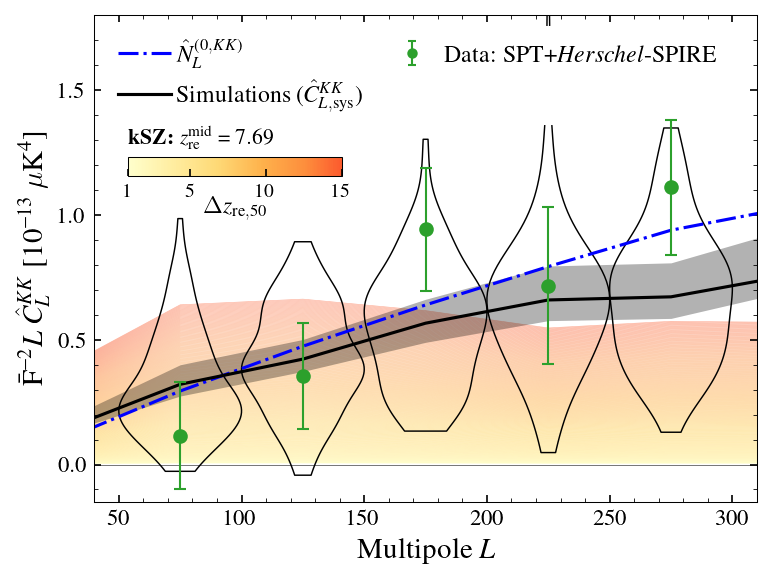

In [6]:
reqd_lmin_lmax = (3300.0, 4300.0) #\ell_min, \ell_max
#fname = 'results/20240220_before_realisingnongaucovincludesgaussiancovaswell/CL_kk_data_sims_amberksz_nzero.npy'
fname = 'results/CL_kk_data_sims_amberksz_nzero.npy'

#read file
res_dict = np.load(fname, allow_pickle=True).item()[reqd_lmin_lmax]
print(res_dict.keys())

scalefac = 1e13

#fsky lost due to source masking/inpainting
#fsky_lost_due_to_source_masking = res_dict['fsky_lost_due_to_source_masking'] #already factored out.

#get values for plotting
L = res_dict['L'] #L bins
cl_kk_cov = res_dict['covariance'] #covariance
cl_kk_err = np.diag(cl_kk_cov)**0.5 #error
cl_kk_N0 = res_dict['N0']
cl_kk_sims_ind_arr = res_dict['sims_individual'] #100 simulations
cl_kk_sims_mean = res_dict['sims'] #sim mean
cl_kk_sims_tsz0p8_mean = res_dict['sims_tsz0p8'] #sims with tSZx0.8 mean
cl_kk_sims_tsz1p2_mean = res_dict['sims_tsz1p2'] #sims with tSZx1.2 mean
if (1):
    ratio_fid_tsz0p8 = np.mean(cl_kk_sims_mean/cl_kk_sims_tsz0p8_mean)
    ratio_fid_tsz1p2 = np.mean(cl_kk_sims_mean/cl_kk_sims_tsz1p2_mean)
    print( ratio_fid_tsz0p8, ratio_fid_tsz1p2 )
cl_kk_sims_mean = res_dict['sims'] #sim mean
cl_kk_data = res_dict['data'] #data
#AMBER
cl_kk_amber_ksz_baseline = res_dict['amber_ksz'] #AMBER-kSZ
amber_fid_z_mid = res_dict['amber_fid_z_mid'] #AMBER fiducial z_min
amber_fid_delta_z_90 = res_dict['amber_fid_delta_z_90'] #AMBER fiducial delta_z_90


clf()
lwval = 1.5
fsval = 14
figure(figsize = (5.7, 4.3))
ax = subplot(111)
dlfac = L
nzerocolor = 'blue'
simcolor = 'black'
datacolor = 'tab:green'

#AMBER-kSZ
maxz = 15.
reqd_delta_z_50_arr = np.arange(1., maxz+.05, 0.05)
reqd_z_re_val = 7.69 #Planck zmid
##amber_colormap = cm.YlGn
amber_colormap = cm.YlOrRd
amber_colormap = tools.truncate_colormap(amber_colormap)
tmpcolorarr = [amber_colormap(int(d)) for d in np.linspace(0, 255, len(reqd_delta_z_50_arr))]
delta_z_50_color_dict = {}
for zzzcntr, zzz in enumerate( reqd_delta_z_50_arr ):
    delta_z_50_color_dict[zzz] = tmpcolorarr[zzzcntr]
amber_ksz_clkk_arr = tools.parent_get_amber_ksz_4pt_using_scaling(reqd_delta_z_50_arr, [reqd_z_re_val], cl_kk_amber_ksz_baseline)
for tmpcntr, reqd_delta_z_50_val in enumerate(reqd_delta_z_50_arr):
    plot(L, dlfac * amber_ksz_clkk_arr[tmpcntr], color = delta_z_50_color_dict[reqd_delta_z_50_val], lw = 0.3, ls = '-', zorder = -100, alpha = 0.5)


'''
#individual sims
for cl_kk_sims_ind in cl_kk_sims_ind_arr:
    plot(L, dlfac * cl_kk_sims_ind, color = simcolor, lw = 0.3, alpha = 0.15)
'''    

#vioilin
for Lcntr, curr_L in enumerate(L):
    if curr_L<50 or curr_L>300: continue
    cl_kk_sims_curr_Lbin = cl_kk_sims_ind_arr[:, Lcntr]
    ##violinplot([dlfac[Lcntr] * cl_kk_sims_curr_Lbin], [curr_L], widths = 50., showextrema = True, showmeans=False, quantiles = [0.16, 0.84], points = 100)
    violins = violinplot([dlfac[Lcntr] * cl_kk_sims_curr_Lbin], [curr_L], widths = 50., showextrema = False, showmeans=False, points = 100)
    for pc in violins['bodies']:        
        pc.set_facecolor('None'); pc.set_edgecolor('black'); pc.set_alpha(1.); pc.set_linestyle('-'); pc.set_linewidth(0.7)
        

    '''
    errorbar(L, dlfac * cl_kk_sims_mean, yerr = dlfac * cl_kk_err, ls = 'None', marker = 'o', ms = 6., color = 'black', elinewidth = 1., capsize = 2., capthick = 1., zorder = 1000)    
    cl_kk_err_v2 = np.std( cl_kk_sims_ind_arr, axis = 0)
    errorbar(L-5., dlfac * cl_kk_sims_mean, yerr = dlfac * cl_kk_err_v2, ls = 'None', marker = 'o', ms = 6., color = 'red', elinewidth = 1., capsize = 2., capthick = 1., zorder = 1000)
    '''

#N0
plot(L, dlfac * cl_kk_N0, color = nzerocolor, ls = '-.', lw = lwval)#, label = r'$N^{(0, KK)}$')

#sims mean
###plot(L, dlfac * cl_kk_sims_tsz0p8_mean, lw = lwval, color = simcolor)
##plot(L, dlfac * cl_kk_sims_tsz1p2_mean, lw = lwval, color = simcolor)
fill_between(L, dlfac * cl_kk_sims_tsz0p8_mean, dlfac * cl_kk_sims_tsz1p2_mean, edgecolor = 'None', lw = 0., color = 'black', alpha = 0.3)
plot(L, dlfac * cl_kk_sims_mean, lw = lwval, color = simcolor)

#data
errorbar(L, dlfac * cl_kk_data, yerr = dlfac * cl_kk_err, ls = 'None', marker = 'o', ms = 6., color = datacolor, mew = 1., elinewidth = 1., capsize = 3., capthick = 1., zorder = 1000)


axhline(lw = 0.25, color = 'black')
ax = tools.format_axis(ax, fsval-3, fsval-3)
xlabel(r'Multipole $L$', fontsize = fsval)
yscaling = 1e-13 ##ax.yaxis.get_major_formatter().get_offset()
ax.yaxis.offsetText.set_visible(False)
ylabel(r'${\rm \bar{F}^{-2}} L\ \hat{C}_{L}^{KK}$ [$10^{%g}$ $\mu$K$^{4}$]' %(np.log10(yscaling)), fontsize = fsval)

#ymin, ymax = -0.1, 0.95
###ymin, ymax = -0.1, 1.
ymin, ymax = -0.15 * yscaling, 1.8 * yscaling
xlim(40., 310.); ylim(ymin, ymax) #ylim(-0.05, 0.4)

ax.yaxis.set_major_locator(plt.MaxNLocator(4))

############################################################
#write legends
'''
fig = plt.gcf()
xloc, yloc = 0.225, 0.795
w, h = 0.2, 0.1
cax = fig.add_axes([xloc, yloc, w, h])
'''
plot([], [], color = nzerocolor, label = r'$\hat{N}_{L}^{(0, KK)}$', lw = lwval, ls = '-.')
plot([], [], color = simcolor, lw = lwval, ls = '-', label = r'Simulations ($\hat{C}_{L,{\rm sys}}^{KK}$)')
errorbar([0.], [0.], yerr = [0.], ls = 'None', label = r'Data: SPT+{\it Herschel}-SPIRE', lw = lwval, marker = 'o', ms = 4., color = datacolor, mew = 1., elinewidth = 1., capsize = 2., capthick = 1., zorder = 1000)
leg = legend(loc = 2, fontsize = fsval-2.5, ncol = 2, handlelength = 2.2, columnspacing=1., framealpha=1., labelspacing = 0.5, handletextpad = 0.2, numpoints = 1)
leg.get_frame().set_color('white')
#axis('off')
if (1): #kSZ colour map
    fig = plt.gcf()
    amber_tickvals = [1., 5., 10., maxz]
    #xloc, yloc = 0.165, yloc - 0.19
    ###xloc, yloc = 0.165, 0.56
    ##xloc, yloc = 0.165, 0.69
    xloc, yloc = 0.165, 0.63
    cax = fig.add_axes([xloc, yloc, 0.25, 0.03], frame_on = True, alpha = 1.)
    figtext(xloc, yloc+.05, r'{\bf kSZ:} $z_{\rm re}^{\rm mid} = %g$' %(reqd_z_re_val), fontsize = fsval-3.5)
    vmin, vmax = 1., max(reqd_delta_z_50_arr)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=amber_colormap, norm=norm, orientation='horizontal', ticks = amber_tickvals, drawedges = 0., format = r'%g')
    cb.set_label(r'$\Delta {z_{\rm re, 50}}$', fontsize=fsval-2.5, labelpad = -2.)#-17., position = (0.6,0.38), horizontalalignment='right')
    cb.ax.tick_params(labelsize=fsval-4.5)
    cb.minorticks_off()
############################################################

plname = 'plots/clkk_data_sims_amber.pdf'
##savefig(plname, dpi=200.)

show()



# Plot 3 - Posteriors for $\Delta z_{\rm re, 50}$ and $z^{\rm mid}_{\rm re}$.

# Plot N - Appendix: Likelihood $\mathcal{L}$ plots for reionisation duration $\Delta_{z}$ w/ and w/o foreground temeplate systematic.

dict_keys([0, 1])
Fit for foregrounds = False
	Parameters present for this case = ['delta_z']
Fit for foregrounds = True
	Parameters present for this case = ['delta_z', 'ampcmbfg']
Fit for foregrounds = False
	Parameters present for this case = ['delta_z']
Fit for foregrounds = True
	Parameters present for this case = ['delta_z', 'ampcmbfg']


<Figure size 900x600 with 0 Axes>

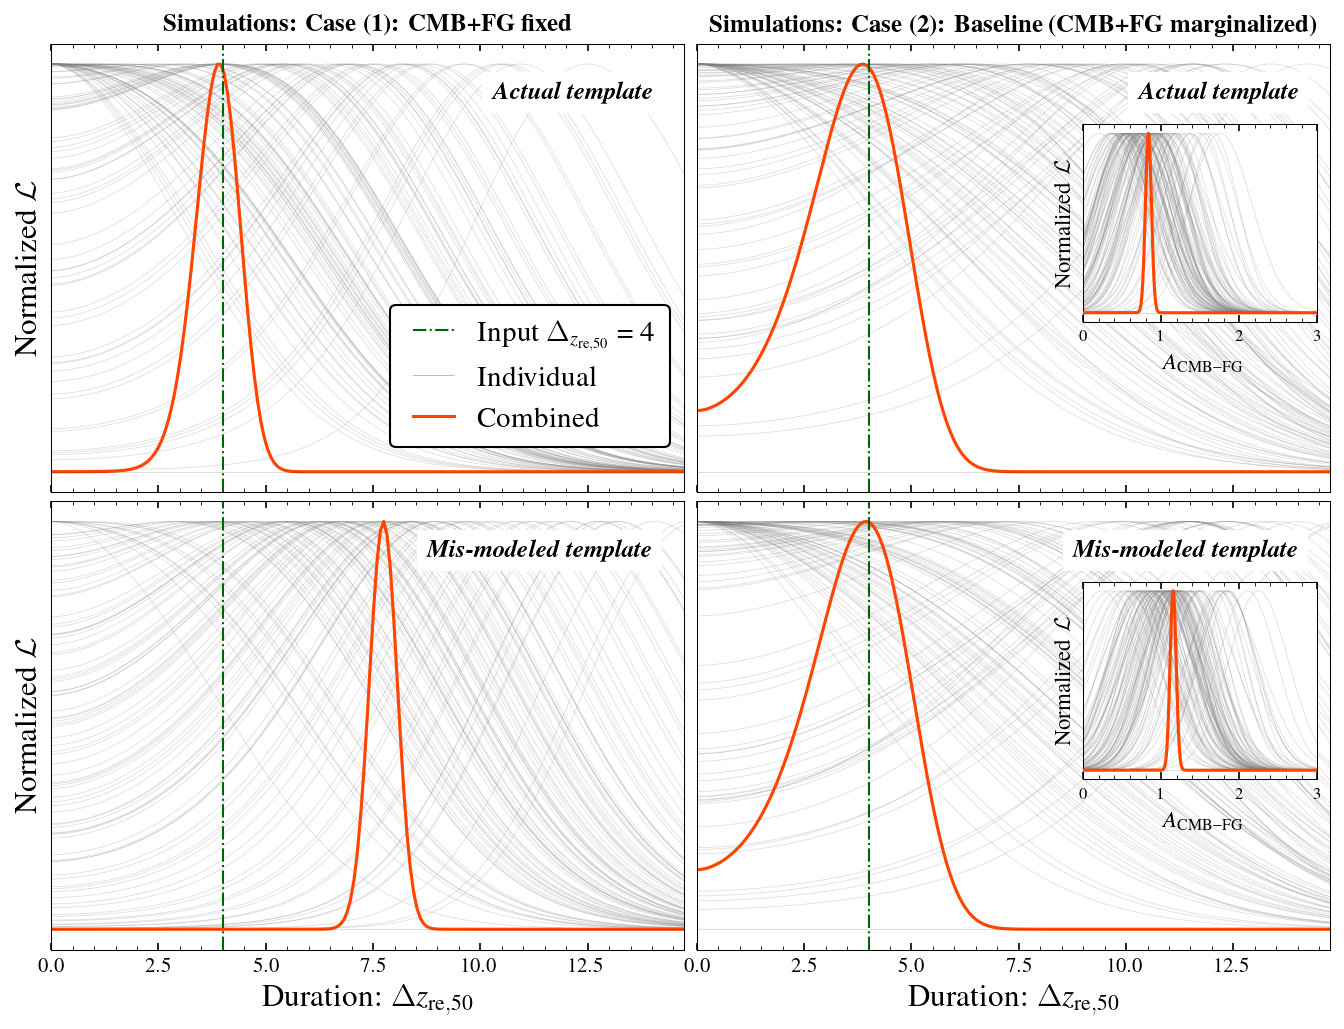

In [7]:
fname = 'results/sims_data_for_likelihood_with_and_without_systematic_for_plotting.npy'

#read file
res_dict = np.load(fname, allow_pickle=True).item()

#keys correpond to Case (A) - A_{CMB+FG} fixed and Case (B) - A_{CMB+FG} marginalised.
fit_for_fg_arr = res_dict.keys()
print(fit_for_fg_arr) 

comp_all_arr = ['cib_cmb_rad_tsz_ksz_noise', 'cib_cmb_rad_tszx1.2_ksz_noise']

ip_delta_z_50_val_for_sims = 4. #for simulations
ind_sim_alphaval = 0.25 #0.5
ind_sim_lwval = 0.4
sim_lwval, sim_lsval = 1.5, '-'
data_lwval, data_lsval = 1.5, '-'
input_lwval, input_lsval = 1., '-.'
arrow_lwval = 2.
sim_color, ind_sim_color = 'orangered', 'gray'

clf()
figure(figsize = (11., 8.))
subplots_adjust(hspace = 0.02, wspace = 0.02)
tr, tc = 2, 2
sbpl = 1
to_store_dic = {}
for comp_all_cntr, comp_all in enumerate( comp_all_arr ):
    if comp_all == 'cib_cmb_rad_tsz_ksz_noise':
        which_estimate_to_remove_for_sims = 'fiducial'
        which_estimate_to_remove_for_sims_str = r'Actual template'
    elif comp_all == 'cib_cmb_rad_tszx1.2_ksz_noise':
        which_estimate_to_remove_for_sims = 'not_same'
        which_estimate_to_remove_for_sims_str = r'Mis-modeled template'

    for fit_for_fg in fit_for_fg_arr:
        if fit_for_fg == 0:
            tit_str = r'Case (1): CMB+FG fixed'
        else:
            tit_str = r'Case (2): Baseline (CMB+FG marginalized)'

        param_arr_to_plot = list(res_dict[fit_for_fg][comp_all][which_estimate_to_remove_for_sims].keys())
        print('Fit for foregrounds = %s' %(bool(fit_for_fg)))
        print('\tParameters present for this case = %s' %(str(param_arr_to_plot)))

        #first plot delta_z
        param_to_plot = 'delta_z'
        xarr, individual_sim_Larr, combined_sim_Larr, best_fit_sim_arr, data_Larr = res_dict[fit_for_fg][comp_all][which_estimate_to_remove_for_sims][param_to_plot]

        ax = subplot(tr, tc, sbpl)
        fsval = 11
        if sbpl <= 2:
            title(r'{\bf Simulations: %s}' %(tit_str), fontsize = 12)
        title(r'{\bf \emph{%s}}' %(which_estimate_to_remove_for_sims_str), fontsize = 12, y = 0.85, x = 0.95, backgroundcolor = 'white', loc = 'right')#, color = 'hotpink')

        #individual sims
        for ind_sim_cntr, ind_sim_L in enumerate( individual_sim_Larr ):
            plot(xarr, ind_sim_L, color = ind_sim_color, alpha = ind_sim_alphaval, lw = ind_sim_lwval, zorder = -100)
            
        #combined sims
        plot(xarr, combined_sim_Larr, color = sim_color, lw = sim_lwval, ls = sim_lsval)
        axvline(ip_delta_z_50_val_for_sims, ls = input_lsval, color = 'darkgreen', lw = input_lwval)

        if fit_for_fg == 0 and sbpl == 1: #write legend
            plot([] , [], color = 'darkgreen', lw = 1., ls = '-.', label = r'Input $\Delta_{z_{\rm re, 50}}$ = %g' %(ip_delta_z_50_val_for_sims))
            plot([] , [], color = ind_sim_color, lw = 0.5, alpha = 0.5, label = r'Individual')
            plot([] , [], color = sim_color, lw = sim_lwval, label = r'Combined' )
            #legend(loc=4, fontsize = fsval+3, framealpha = 1.)
            legend(bbox_to_anchor=(1., 0.45), fontsize = fsval+3, framealpha = 1., handletextpad = 0.5)

        xlabval = r'Duration: %s' %(tools.get_latex_param_str(param_to_plot))

        if sbpl <= 2:
            setp(ax.get_xticklabels(which = 'both'), visible=False)
        else:
            xlabel(xlabval, fontsize = fsval+4)#, labelpad = labelpad)#, backgroundcolor = 'white')
        if sbpl == 1 or sbpl == 3:
            ylabel(r'Normalized $\mathcal{L}$', fontsize = fsval+4)#, backgroundcolor = 'white')
        setp(ax.get_yticklabels(which = 'both'), visible=False)
        ax.tick_params(axis='y', which='both', length=0)

        xmin, xmax = 0., 14.75
        xlim(xmin, xmax)
        ylim(-0.05, 1.05)
        axhline(lw = 0.25, alpha = 0.25)
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))

        #inset plot for A_{CMB+FG}
        if fit_for_fg:
            fsval = 10
            rect=[0.61,0.38,0.37,0.44]
            ax2=tools.add_subplot_axes(ax,rect)
            ax2.set_facecolor('white')

            param_to_plot = 'ampcmbfg'
            xarr, individual_sim_Larr, combined_sim_Larr, best_fit_sim_arr, data_Larr = res_dict[fit_for_fg][comp_all][which_estimate_to_remove_for_sims][param_to_plot]

            #individual sims
            for ind_sim_L in individual_sim_Larr:
                plot(xarr, ind_sim_L, color = ind_sim_color, alpha = ind_sim_alphaval, lw = ind_sim_lwval, zorder = -100)
                
            #combined sims
            plot(xarr, combined_sim_Larr, color = sim_color, zorder = 100, lw = sim_lwval, ls = sim_lsval)

            xlabval = r'%s' %(tools.get_latex_param_str(param_to_plot))
            xlabel(xlabval, fontsize = fsval+1)#, labelpad = labelpad)#, backgroundcolor = 'white')
            ylabel(r'Normalized $\mathcal{L}$', fontsize = fsval+1)#, backgroundcolor = 'white')
            setp(ax2.get_yticklabels(which = 'both'), visible=False)
            ax2.tick_params(axis='y', which='both', length=0)

            xmin, xmax = 0., 3.
            xlim(xmin, xmax)
            ylim(-0.05, 1.05)
            axhline(lw = 0.25, alpha = 0.25)
            ax2=tools.format_axis(ax2, fsval-2, fsval-2)
            ax2.xaxis.set_major_locator(plt.MaxNLocator(3))

        sbpl+=1
plname = 'plots/delta_z_posterior_sims_with_and_without_systematic.pdf'
##savefig(plname, dpi = 200.)
show()    


# Plot 5 - Appendix - Posteriors for $\Delta z_{\rm re, 50}$, $z^{\rm mid}_{\rm re}$, and $A_{\rm CMB+FG}$.